In [1]:
%matplotlib inline
import os
import sys
import re
import copy
import numpy as np
import pickle
from scipy.optimize import fmin
import multiprocessing as mp
import functools
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from itertools import product
from scipy.optimize import minimize

In [2]:
%load_ext autoreload
%autoreload 2

In [35]:
# statmech library setup
sys.path.append('../../statmechlib')
from statmechlib.preprocessing import select_nodes, to_param_dict, to_param_list, tpf_to_bsplines
from statmechlib.preprocessing import Trajectory, scale_configuration, pair_dist_cutoff, find_index
from statmechlib.preprocessing import universal_eos, downselect
from statmechlib.read_write import params_to_pickle
from statmechlib.forcefields import u_core, penalty_matrix, make_input_matrices
from statmechlib.forcefields import f_embed, f_dens, f_spline3, energy
from statmechlib.forcefields import loss_energy_penalized, jacobian_energy_penalized, loss_sd2_penalized, jacobian_sd2_penalized

In [4]:
working = '../data/working'

In [5]:
# params_file = 'marinica_params'
# with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
#     param_list = pickle.load(fi)  

In [6]:
params_file = 'marinica_bs'
with open(os.path.join(working, params_file + '.pickle'), 'rb') as fi:
    param_list = pickle.load(fi)

In [7]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)

In [8]:
binom = [1.0, -4.0, 6.0, -4.0, 1.0]

def make_bspline(coeffs, k, r):
    """
    Calculate energy from a cubic b-spline-based potential
    """
    
    u = 0.0
    for i, c in enumerate(coeffs):        
        for j, b in enumerate(binom):
            # truncated polynomial basis function
            tpf = (k[i+j]-r)**3 if r < k[i+j] else 0.0
            
            # contribution to potential from a b-spline basis function component
            u += c*b*tpf
            #u += c*b*tpf(r, k[i+j])
        
    return u

In [55]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpf = pickle.load(fi, encoding='latin1')

stats_bspline = tpf_to_bsplines(stats_tpf)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targets = pickle.load(fi, encoding='latin1')

len 50


In [56]:
targets['eos']['box'] = targets['eos']['box'][0:1]
targets['eos']['xyz'] = targets['eos']['xyz'][0:1]
targets['eos']['temp'] = targets['eos']['temp'][0:1]
targets['eos']['beta'] = targets['eos']['beta'][0:1]
targets['eos']['energy'] = targets['eos']['energy'][0:1]
stats_bspline['eos']['energy'] = stats_bspline['eos']['energy'][0:1]

In [57]:
targets['eos_bcc']['box'] = targets['eos_bcc']['box'][0:5]
targets['eos_bcc']['xyz'] = targets['eos_bcc']['xyz'][0:5]
targets['eos_bcc']['temp'] = targets['eos_bcc']['temp'][0:5]
targets['eos_bcc']['beta'] = targets['eos_bcc']['beta'][0:5]
targets['eos_bcc']['energy'] = targets['eos_bcc']['energy'][0:5]
stats_bspline['eos_bcc']['energy'] = stats_bspline['eos_bcc']['energy'][0:5]

In [58]:
targets['relax']['box'][1] = targets['inf']['box'][0]
targets['relax']['xyz'][1] = targets['inf']['xyz'][0]
targets['relax']['temp'][1] = targets['inf']['temp'][0]
targets['relax']['beta'][1] = targets['inf']['beta'][0]
targets['relax']['energy'][1] = targets['inf']['energy'][0]
stats_bspline['relax']['energy'][1] = stats_bspline['inf']['energy'][0]

In [59]:
edens_knots = list(np.linspace(1.05, 4.45, 35))
pair_knots = list(np.linspace(1.05, 5.05, 41))

print(edens_knots)
print(pair_knots)

stats_list = [downselect(stats_bspline, pair_knots, edens_knots, bspline=True)]

[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45]
[1.05, 1.1500000000000001, 1.25, 1.35, 1.4500000000000002, 1.55, 1.6500000000000001, 1.75, 1.85, 1.9500000000000002, 2.05, 2.1500000000000004, 2.25, 2.35, 2.45, 2.55, 2.6500000000000004, 2.75, 2.85, 2.95, 3.05, 3.1500000000000004, 3.25, 3.3500000000000005, 3.45, 3.55, 3.6500000000000004, 3.75, 3.8500000000000005, 3.95, 4.05, 4.15, 4.25, 4.3500000000000005, 4.45, 4.55, 4.65, 4.75, 4.8500000000000005, 4.95, 5.05]


In [60]:
tkeys = ['bcc_npt_langevin_300K',
 'bcc_npt_langevin_3700K',
 'fcc_npt_langevin_300K',
 'vac_npt_langevin_2000K',
 'i110_npt_langevin_2000K',
 'i111_npt_langevin_2000K',
 'screw_111_npt_langevin_2000K',
 'liq_3700K',
 'liq_5000K',
 'eos',
 'eos_bcc',
 'eos_fcc',
 'vacint',
 'bain',
 'relax']

In [61]:
targets['eos_fcc']['weight'] = 0.0
targets['bain']['weight'] = 0.0 #0.1
targets['eos']['weight'] = 0.0 #1e-4
targets['eos_bcc']['weight'] = 0.0 #0.1
targets['relax']['weight'] = 10.0
targets['inf']['weight'] = 0.0
targets['vacint']['weight'] = 0.0
targets['fcc_npt_langevin_300K']['weight'] = 1.0
targets['bcc_npt_langevin_300K']['weight'] = 5.0
targets['bcc_npt_langevin_3700K']['weight'] = 3.0
# targets['screw_111_npt_langevin_2000K']['weight'] = 0.0
# targets['vac_npt_langevin_2000K']['weight'] = 0.0
# targets['i111_npt_langevin_2000K']['weight'] = 0.0
# targets['i110_npt_langevin_2000K']['weight'] = 0.0

#targets['liq_5000K']['weight'] = 0.1
[(key, targets[key]['weight']) for key in targets.keys()]

[('bcc_npt_langevin_3700K', 3.0),
 ('liq_5000K', 1.0),
 ('vac_npt_langevin_2000K', 1.0),
 ('relax', 10.0),
 ('screw_111_npt_langevin_2000K', 1.0),
 ('i110_npt_langevin_2000K', 1.0),
 ('bcc_npt_langevin_300K', 5.0),
 ('i111_npt_langevin_2000K', 1.0),
 ('eos', 0.0),
 ('fcc_npt_langevin_300K', 1.0),
 ('vacint', 0.0),
 ('eos_fcc', 0.0),
 ('inf', 0.0),
 ('liq_3700K', 1.0),
 ('eos_bcc', 0.0),
 ('bain', 0.0)]

In [62]:
targets['eos']['temp'][0] = 10000.0
targets['eos']['energy'][0] = 20000.0
targets['eos']['energy']

[20000.0]

## SD matching

**Parameters optimized only on energetics**

In [64]:
b_init = np.array([-2.04920533e-05,  4.92052109e+03,  4.28623431e+03,  3.70070247e+03,
        3.16382385e+03,  2.67569067e+03,  2.23622781e+03,  1.84518613e+03,
        1.50161718e+03,  1.20381579e+03,  9.49384224e+02,  7.35040802e+02,
        5.56972724e+02,  4.11494286e+02,  2.95866025e+02,  2.08083904e+02,
        1.44489253e+02,  9.95452445e+01,  6.94800739e+01,  5.06741347e+01,
        3.98624976e+01,  3.52521990e+01,  3.45203247e+01,  3.57049415e+01,
        3.72857552e+01,  3.86160092e+01,  3.87068338e+01,  3.71049783e+01,
        3.41424994e+01,  2.97274488e+01,  2.41269472e+01,  1.76936419e+01,
        1.13842989e+01,  6.44748138e+00,  3.38042172e+00,  1.95572488e+00,
        2.39092415e+00,  3.99575276e+00,  5.02233698e+00,  3.89348064e+00,
        2.59529763e+00, -6.45149582e-01, -1.59201221e+04, -9.86694867e+03,
       -4.72359780e+03, -4.92744340e+02,  2.82802854e+03,  5.24671589e+03,
        6.80223801e+03,  7.56325690e+03,  7.64588244e+03,  7.19428377e+03,
        6.38934836e+03,  5.44792480e+03,  4.57071556e+03,  3.80418690e+03,
        3.04660960e+03,  2.41003818e+03,  2.00705151e+03,  1.65731699e+03,
        1.39906959e+03,  1.23354108e+03,  1.08070447e+03,  9.33281650e+02,
        8.10007541e+02,  7.20340999e+02,  5.91835787e+02,  5.11000712e+02,
        4.70747331e+02,  3.88928765e+02,  3.12207596e+02,  2.30842537e+02,
        1.48780551e+02,  1.06289409e+02,  5.88390236e+01,  7.43091685e+00,
       -6.43889196e+00])

In [65]:
scale = np.ones((len(pair_knots)))*0.25
len(pair_knots), len(edens_knots), len(b_init)

(41, 35, 77)

In [66]:
alpha = 1.0

# 3rd order penalty for larger distances
partitions = []
partitions.append([1, None, None, None, None]) # Embedding function - no penalty
partitions.append([len(pair_knots), 3, scale, [], []])
partitions.append([len(edens_knots), 3, np.ones((len(edens_knots)))*0.005, [], []])

Dp3, Cp3, c3 = penalty_matrix(partitions)
print(c3, Cp3, Dp3[:])

results = []
for i, stat in enumerate(stats_list[-1:]):

    
    penalty_type = 'sd2'  #'energy'
    if penalty_type == 'energy':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys)

        # assign weights to individual configurations
        weight_config = np.empty((len(y),), dtype=float)
        for i_trj, bound_slice in enumerate(bounds):
            weight_config[bound_slice] = weight[i_trj]

        loss = loss_energy_penalized
        jac = jacobian_energy_penalized
        args = (X, y, weight_config, Dp3, alpha)

    elif penalty_type == 'sd2':
        X, y, weight, beta, bounds = make_input_matrices(targets, stat, keytrj=tkeys, combined=0.35)

        loss = loss_sd2_penalized
        jac = jacobian_sd2_penalized
        alpha *= 1e-8
        # add an extra total trajectory
        #weight = np.append(weight, np.array([1.0]))
        #bounds = np.append(bounds, np.array(slice(0, len(y), 1)))
        args = (X, y, weight, bounds, beta, Dp3, alpha)
    
    #results.append(minimize(loss, b_init, args=args, jac=jac, options={'maxiter':10000}))
    #results.append(minimize(loss, b_init, args=args, options={'maxiter':10000}))
    results.append(minimize(loss, b_init, args=args, method='Nelder-Mead', options={'maxiter':10000}))


    #results.append(minimize(loss_energy_penalized, b_init, args=(X, y, weight, Dp3, alpha), jac=jacobian_energy_penalized, options={'maxiter':10000}))
    

0.0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0.] [[ 0.000e+00  0.000e+00  0.000e+00 ...  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00  6.250e-02 -1.875e-01 ...  0.000e+00  0.000e+00  0.000e+00]
 [ 0.000e+00 -1.875e-01  6.250e-01 ...  0.000e+00  0.000e+00  0.000e+00]
 ...
 [ 0.000e+00  0.000e+00  0.000e+00 ...  4.750e-04 -3.000e-04  7.500e-05]
 [ 0.000e+00  0.000e+00  0.000e+00 ... -3.000e-04  2.500e-04 -7.500e-05]
 [ 0.000e+00  0.000e+00  0.000e+00 ...  7.500e-05 -7.500e-05  2.500e-05]]
bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1395, 1), slice(0, 1595, 1)]
weights [5.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 10.0, 0.35]
5.673044759229187e

5.524892544717345e-05 5.51552161407531e-05 9.370930642034921e-08
1.3020464267607305e-05 1.293210290148132e-05 8.836136612598552e-08
5.139355970625457e-05 5.1135645078310576e-05 2.5791462794399536e-07
1.291512855054983e-05 1.2791281662622045e-05 1.2384688792778406e-07
5.2164559971927806e-05 4.941922384843846e-07 5.167036773344342e-05
1.2707088982378163e-05 4.816552918748212e-07 1.2225433690503342e-05
5.2666603843376194e-05 5.257326605151845e-05 9.333779185774461e-08
1.216155336859303e-05 1.207067220856193e-05 9.08811600310986e-08
4.69654944067617e-05 4.68593834274552e-05 1.0611097930649976e-07
1.2093451082343245e-05 1.1996364717305536e-05 9.708636503771004e-08
4.531878031311509e-05 4.522960678615724e-05 8.917352695784985e-08
1.0821157185233966e-05 1.0725375302834622e-05 9.578188239934434e-08
4.342686507725398e-05 4.314416309116638e-05 2.827019860876021e-07
1.0953479723520138e-05 1.0829824018975562e-05 1.236557045445761e-07
4.0398036696254225e-05 4.967622267947683e-07 3.990127446945946e-

2.590969571114224e-06 2.49781678152305e-06 9.315278959117422e-08
1.0620932138160409e-06 9.723373479871886e-07 8.975586582885228e-08
2.6277201558795986e-06 2.53719989611151e-06 9.052025976808864e-08
1.044285151538228e-06 9.56161730809384e-07 8.812342072884406e-08
2.281432718903636e-06 4.824637905526853e-07 1.7989689283509507e-06
9.756485795673225e-07 4.799575831143457e-07 4.956909964529768e-07
2.2667000747249055e-06 2.179275157829281e-06 8.74249168956247e-08
9.502321742994777e-07 8.611603445946837e-07 8.907182970479397e-08
2.213580609869532e-06 8.994885751697527e-07 1.3140920346997792e-06
9.455474835956843e-07 5.607805926797973e-07 3.8476689091588695e-07
2.1883707763594524e-06 2.09790122244116e-06 9.046955391829216e-08
9.114149779456101e-07 8.229703367493788e-07 8.844464119623127e-08
1.8793664787564323e-06 1.790005579106347e-06 8.936089965008534e-08
1.9898424609002116e-06 4.821337495959355e-07 1.5077087113042762e-06
9.005181944353628e-07 4.79993772165558e-07 4.205244222698048e-07
1.9291

6.115807693740191e-07 5.233062822724969e-07 8.827448710152212e-08
7.489035795508135e-07 6.607547812796461e-07 8.81487982711674e-08
6.102130859827053e-07 5.22000279272174e-07 8.82128067105313e-08
7.445825620768193e-07 4.797730938039314e-07 2.648094682728879e-07
6.106130337703935e-07 4.795313254464208e-07 1.3108170832397264e-07
7.468835444947185e-07 4.791842155097375e-07 2.67699328984981e-07
6.090023495735536e-07 4.793159641631762e-07 1.2968638541037733e-07
7.55287142234818e-07 6.668192572903868e-07 8.846788494443117e-08
6.078545514799403e-07 5.195557856054038e-07 8.829876587453654e-08
7.519911537252908e-07 6.559601185383768e-07 9.603103518691398e-08
6.062960683092544e-07 5.188404217187122e-07 8.745564659054225e-08
7.387006247803572e-07 6.505324958912717e-07 8.816812888908558e-08
6.058687145577552e-07 5.17556841172072e-07 8.831187338568328e-08
7.427773466822783e-07 6.556777686793269e-07 8.70995780029513e-08
6.05280867327656e-07 5.124627446916308e-07 9.281812263602518e-08
7.13699639554710

6.048479680472034e-07 5.018683347788018e-07 1.0297963326840161e-07
5.759959348437892e-07 4.849630180308187e-07 9.103291681297051e-08
6.025258830417478e-07 4.79525616020941e-07 1.2300026702080685e-07
5.761360038549923e-07 4.793198657732773e-07 9.681613808171505e-08
6.019870998278082e-07 5.142025759251782e-07 8.778452390262998e-08
5.75449427550734e-07 4.871050949679199e-07 8.834433258281408e-08
6.030058110607791e-07 5.152348792205333e-07 8.777093184024566e-08
5.752347312293205e-07 4.870027170477048e-07 8.823201418161574e-08
6.004444997340146e-07 4.792763257414636e-07 1.2116817399255097e-07
5.755000250183656e-07 4.793404264172823e-07 9.615959860108333e-08
6.005403106961937e-07 4.806864930744056e-07 1.1985381762178805e-07
5.75455730239728e-07 4.798806381787777e-07 9.557509206095034e-08
5.996610943801109e-07 4.794861643128099e-07 1.201749300673009e-07
5.753380201724236e-07 4.793476904497039e-07 9.599032972271971e-08
5.999007392812017e-07 4.795183124073513e-07 1.2038242687385036e-07
5.748983

5.769089468903859e-07 4.836512701786535e-07 9.32576767117324e-08
5.697005857860191e-07 4.805258220563489e-07 8.917476372967016e-08
5.770141532567825e-07 4.879050316958884e-07 8.91091215608941e-08
5.696307195139558e-07 4.819242028710244e-07 8.770651664293141e-08
5.7828204075405e-07 4.900907617611505e-07 8.819127899289953e-08
5.69412927643153e-07 4.81413658220498e-07 8.7999269422655e-08
5.786150495467722e-07 4.904760041917175e-07 8.813904535505458e-08
5.693511121108544e-07 4.81326955092465e-07 8.802415701838938e-08
5.770922442217098e-07 4.904541960951984e-07 8.663804812651137e-08
5.695015951255503e-07 4.80546859305585e-07 8.895473581996526e-08
5.75850601199767e-07 4.795033229986384e-07 9.634727820112858e-08
5.770635593091036e-07 4.888327674007381e-07 8.823079190836545e-08
5.693948023533376e-07 4.813981493561597e-07 8.799665299717787e-08
5.77138560639345e-07 4.853281815768707e-07 9.181037906247425e-08
5.693448101208913e-07 4.806674821734347e-07 8.867732794745663e-08
5.76130420389281e-07 4

5.697236159279832e-07 4.792689594279515e-07 9.045465650003167e-08
5.703783309760963e-07 4.816055792532187e-07 8.877275172287767e-08
5.678982718392912e-07 4.793240269951272e-07 8.857424484416413e-08
5.698136620724433e-07 4.820804298835668e-07 8.773323218887648e-08
5.701536309737316e-07 4.822098857288076e-07 8.794374524492401e-08
5.678834805117689e-07 4.798487895733619e-07 8.803469093840704e-08
5.705079632725999e-07 4.824025184795783e-07 8.810544479302167e-08
5.67840097282559e-07 4.798843123724238e-07 8.79557849101353e-08
5.703944114809228e-07 4.824914936199006e-07 8.790291786102217e-08
5.678385279415542e-07 4.797928477447529e-07 8.804568019680126e-08
5.697758147010728e-07 4.813454486025461e-07 8.843036609852675e-08
5.701759800263194e-07 4.828714282331143e-07 8.730455179320501e-08
5.678535678607357e-07 4.794436720715257e-07 8.840989578921004e-08
5.701153207922479e-07 4.810711941078962e-07 8.904412668435171e-08
5.678548421467209e-07 4.794906947854167e-07 8.836414736130422e-08
5.6988956299

5.674979722115338e-07 4.792674117325026e-07 8.823056047903122e-08
5.682918038116759e-07 4.802797640026741e-07 8.801203980900183e-08
5.674842069824229e-07 4.795016657889533e-07 8.79825411934695e-08
5.680478395994894e-07 4.799066030164815e-07 8.814123658300779e-08
5.683161102880841e-07 4.803440251347386e-07 8.797208515334546e-08
5.674645129941176e-07 4.794120397419931e-07 8.805247325212449e-08
5.682968181270843e-07 4.802746570015932e-07 8.802216112549104e-08
5.674535408985701e-07 4.794795275794688e-07 8.797401331910137e-08
5.682915678414389e-07 4.803498075074558e-07 8.794176033398309e-08
5.674462649574025e-07 4.794255440803248e-07 8.80207208770777e-08
5.680804155452256e-07 4.793806725717281e-07 8.869974297349749e-08
5.682615129628522e-07 4.79782415713992e-07 8.847909724886016e-08
5.674355225052424e-07 4.7945527815374e-07 8.798024435150239e-08
5.680990141450445e-07 4.805422398634407e-07 8.755677428160375e-08
5.674541742200407e-07 4.79143926813424e-07 8.831024740661662e-08
5.68108465315404

5.675681731169298e-07 4.792529716395876e-07 8.831520147734217e-08
5.673052924458008e-07 4.792407479948974e-07 8.806454445090346e-08
5.676343147477078e-07 4.7959142272456e-07 8.804289202314784e-08
5.672961288601597e-07 4.793246895397888e-07 8.797143932037095e-08
5.675201570509372e-07 4.792584512341368e-07 8.826170581680042e-08
5.67387195291895e-07 4.796517560308689e-07 8.773543926102604e-08
5.674690332193274e-07 4.792349718602083e-07 8.82340613591191e-08
5.675510298319201e-07 4.794000161513301e-07 8.81510136805899e-08
5.672977042169565e-07 4.791758074524529e-07 8.812189676450352e-08
5.675577317172194e-07 4.792462212614296e-07 8.831151045578978e-08
5.6729657311411e-07 4.792509012290338e-07 8.804567188507619e-08
5.674200993246073e-07 4.795369821631284e-07 8.788311716147888e-08
5.675320130461377e-07 4.792333096571468e-07 8.829870338899085e-08
5.672977219841217e-07 4.792595269512264e-07 8.803819503289524e-08
5.67570796006932e-07 4.795727019183503e-07 8.799809408858181e-08
5.672926872784379e

5.673002063918628e-07 4.79309512233111e-07 8.799069415875181e-08
5.673333107125761e-07 4.793206745534163e-07 8.801263615915971e-08
5.672397178655743e-07 4.792571047772666e-07 8.798261308830767e-08
5.673128579002318e-07 4.793972328143115e-07 8.79156250859203e-08
5.67356871660566e-07 4.793817157874709e-07 8.797515587309505e-08
5.6723505231097e-07 4.79272225861733e-07 8.796282644923693e-08
5.673746831160977e-07 4.79239454984513e-07 8.813522813158471e-08
5.672328575559949e-07 4.792513615512832e-07 8.798149600471163e-08
5.673104991172912e-07 4.793600497340514e-07 8.795044938323984e-08
5.673329683228258e-07 4.79358954120751e-07 8.797401420207479e-08
5.672376492848948e-07 4.792748339515485e-07 8.796281533334629e-08
5.673245007715659e-07 4.792465158272589e-07 8.807798494430692e-08
5.672379939451929e-07 4.792476972815519e-07 8.7990296663641e-08
5.673151548687162e-07 4.79416852810072e-07 8.789830205864427e-08
5.673425499476353e-07 4.792662556594988e-07 8.807629428813648e-08
5.672352046990667e-07

5.672419746755209e-07 4.793377850399195e-07 8.790418963560143e-08
5.672696858528815e-07 4.793376462290599e-07 8.793203962382159e-08
5.672112300791989e-07 4.792397859444525e-07 8.797144413474634e-08
5.672102192567603e-07 4.791847583628669e-07 8.802546089389345e-08
5.672163397391118e-07 4.793069139823886e-07 8.790942575672312e-08
5.672928962978377e-07 4.7927494622027e-07 8.801795007756767e-08
5.672074210074685e-07 4.792766662641439e-07 8.793075474332454e-08
5.672485594887404e-07 4.791839659257166e-07 8.806459356302376e-08
5.672722611045748e-07 4.793196904244659e-07 8.795257068010891e-08
5.672096081425111e-07 4.79254343211466e-07 8.79552649310451e-08
5.672119469220349e-07 4.792549432996913e-07 8.795700362234357e-08
5.672717156179914e-07 4.791355685542671e-07 8.813614706372427e-08
5.672088267177337e-07 4.793374895665178e-07 8.787133715121584e-08
5.672348788181493e-07 4.792403749612112e-07 8.799450385693803e-08
5.672341216324214e-07 4.792919096924941e-07 8.794221193992733e-08
5.672179104992

5.671970331616697e-07 4.792607551257695e-07 8.793627803590013e-08
5.672005557678095e-07 4.792565011724717e-07 8.794405459533778e-08
5.671810063270745e-07 4.793121127800546e-07 8.786889354701998e-08
5.671931506003443e-07 4.793454257966199e-07 8.784772480372439e-08
5.672110809005299e-07 4.792760891390667e-07 8.793499176146313e-08
5.671853796663421e-07 4.792530420514536e-07 8.793233761488857e-08
5.671954971365103e-07 4.792507796157265e-07 8.79447175207838e-08
5.671637122850209e-07 4.792514121106511e-07 8.791230017436973e-08
5.671701724146147e-07 4.792758853336139e-07 8.78942870810009e-08
5.672156940865865e-07 4.792716614707005e-07 8.794403261588607e-08
5.671840626758178e-07 4.792559879611288e-07 8.79280747146889e-08
5.671973447461872e-07 4.79250731921045e-07 8.79466128251422e-08
5.672031000819899e-07 4.792550905226175e-07 8.794800955937241e-08
5.671855057429586e-07 4.791839407501525e-07 8.800156499280612e-08
5.67212522701213e-07 4.792393168292888e-07 8.797320587192423e-08
5.67183685037146

5.671864939739407e-07 4.793458259877418e-07 8.784066798619897e-08
5.671480636318027e-07 4.792250702276613e-07 8.792299340414147e-08
5.671504934976757e-07 4.79218942563262e-07 8.79315509344137e-08
5.67182574449916e-07 4.792554653350275e-07 8.792710911488847e-08
5.671691965109133e-07 4.792343202718748e-07 8.793487623903857e-08
5.671866849431842e-07 4.792478539578099e-07 8.793883098537435e-08
5.671665094394615e-07 4.792397391377112e-07 8.792677030175021e-08
5.671876998297397e-07 4.791685253479942e-07 8.80191744817455e-08
5.671663532583167e-07 4.792829223943294e-07 8.788343086398734e-08
5.67175130942187e-07 4.792432809480988e-07 8.793184999408815e-08
5.671770507006912e-07 4.79223957049522e-07 8.795309365116922e-08
5.671789775735799e-07 4.792311806932034e-07 8.794779688037651e-08
5.671814987197049e-07 4.792290307936188e-07 8.795246792608615e-08
5.671822317563549e-07 4.792992554315119e-07 8.788297632484294e-08
5.671781518263036e-07 4.793237241113544e-07 8.785442771494914e-08
5.67146440660349

5.671602869252097e-07 4.792163212240614e-07 8.794396570114828e-08
5.671618939071693e-07 4.792234512014507e-07 8.793844270571861e-08
5.671374355036727e-07 4.792030684273721e-07 8.793436707630064e-08
5.671329656492602e-07 4.792115819177379e-07 8.79213837315222e-08
5.671633549620161e-07 4.792968933991585e-07 8.786646156285751e-08
5.67155707636265e-07 4.792196314121119e-07 8.793607622415316e-08
5.671569768464096e-07 4.792340780444741e-07 8.792289880193551e-08
5.671612270359579e-07 4.792551299946194e-07 8.790609704133857e-08
5.671598500674763e-07 4.792208410321197e-07 8.793900903535665e-08
5.671602574750631e-07 4.792208559311019e-07 8.793940154396115e-08
5.671340571572854e-07 4.791974364329931e-07 8.793662072429229e-08
5.671394155053498e-07 4.792173113886283e-07 8.792210411672152e-08
5.671605219044688e-07 4.791738947168996e-07 8.798662718756916e-08
5.671342234398531e-07 4.791929869795712e-07 8.794123646028184e-08
5.67156772951015e-07 4.792633413474316e-07 8.789343160358335e-08
5.67137040342

5.671173075824742e-07 4.791818676645306e-07 8.793543991794365e-08
5.670982241517895e-07 4.791628748897973e-07 8.793534926199222e-08
5.671083886843755e-07 4.791909372100825e-07 8.791745147429292e-08
5.671296875479269e-07 4.791884016916885e-07 8.794128585623842e-08
5.6712863036423e-07 4.792447561921985e-07 8.788387417203155e-08
5.671170069028329e-07 4.791652459823494e-07 8.795176092048358e-08
5.670975827743579e-07 4.791839023921932e-07 8.791368038216462e-08
5.671055361498304e-07 4.7918045949063e-07 8.792507665920041e-08
5.671024423294812e-07 4.791994001273851e-07 8.790304220209606e-08
5.671072816819647e-07 4.791986384503527e-07 8.790864323161203e-08
5.670928495209147e-07 4.79151233547095e-07 8.794161597381966e-08
5.670853121391861e-07 4.791186919559269e-07 8.796662018325921e-08
5.670901675027064e-07 4.791612374112107e-07 8.792893009149573e-08
5.671181931594589e-07 4.79202360258901e-07 8.79158329005579e-08
5.671258688240664e-07 4.791956214411746e-07 8.793024738289177e-08
5.670906024378015

5.670656657835603e-07 4.790626369940136e-07 8.800302878954671e-08
5.67051269153127e-07 4.791352847500348e-07 8.791598440309215e-08
5.67055142385703e-07 4.791536056497604e-07 8.790153673594251e-08
5.670612592679441e-07 4.791107891891702e-07 8.795047007877392e-08
5.670648310488658e-07 4.791314123141811e-07 8.793341873468474e-08
5.670567333556705e-07 4.791222484888517e-07 8.793448486681876e-08
5.670703208800534e-07 4.791444800173343e-07 8.792584086271915e-08
5.670351798003872e-07 4.790873684118758e-07 8.794781138851142e-08
5.670517573054069e-07 4.790719185477123e-07 8.797983875769454e-08
5.670421205871065e-07 4.791084063162051e-07 8.793371427090143e-08
5.670501452285266e-07 4.791038886180783e-07 8.79462566104483e-08
5.670374303989954e-07 4.791058139898781e-07 8.793161640911729e-08
5.67052337719928e-07 4.791059870297115e-07 8.794635069021645e-08
5.670749869984306e-07 4.791410752494104e-07 8.793391174902028e-08
5.670380430594138e-07 4.791442783780953e-07 8.789376468131852e-08
5.670397055473

5.669883269817002e-07 4.789787612008748e-07 8.800956578082532e-08
5.670091654789184e-07 4.789814516703879e-07 8.802771380853049e-08
5.670344613005658e-07 4.790956678162429e-07 8.793879348432285e-08
5.669889619009741e-07 4.790121053504206e-07 8.79768565505536e-08
5.669789035719652e-07 4.79008651491032e-07 8.797025208093313e-08
5.669703703018987e-07 4.789771539980761e-07 8.799321630382253e-08
5.670180130433614e-07 4.790429490344084e-07 8.797506400895298e-08
5.669843726553139e-07 4.790320127819061e-07 8.795235987340782e-08
5.670317355443915e-07 4.790516357310314e-07 8.798009981336022e-08
5.67012601390046e-07 4.790492797897072e-07 8.796332160033884e-08
5.66989746335897e-07 4.790341494051664e-07 8.795559693073048e-08
5.670349752760878e-07 4.790964210580614e-07 8.793855421802644e-08
5.670060994424427e-07 4.79039135728921e-07 8.796696371352169e-08
5.670046913700884e-07 4.790390253514009e-07 8.796566601868747e-08
5.66989286057249e-07 4.78970015463591e-07 8.801927059365792e-08
5.670132852098297

5.669361326218228e-07 4.789081535941984e-07 8.802797902762435e-08
5.669321255890226e-07 4.789838993607771e-07 8.794822622824548e-08
5.669350787447689e-07 4.78915765526311e-07 8.801931321845782e-08
5.669300065655003e-07 4.789124590604638e-07 8.801754750503647e-08
5.669623345775922e-07 4.789548991805473e-07 8.800743539704489e-08
5.669337323727261e-07 4.789167449652072e-07 8.801698740751893e-08
5.669439666051182e-07 4.789777841838496e-07 8.796618242126855e-08
5.669330671539751e-07 4.789150617351741e-07 8.801800541880109e-08
5.669578769191077e-07 4.790002353818187e-07 8.795764153728897e-08
5.669476815521952e-07 4.789003296073632e-07 8.804735194483194e-08
5.669483788831957e-07 4.789660726411801e-07 8.798230624201562e-08
5.669292661956296e-07 4.789315433282604e-07 8.799772286736924e-08
5.669432422202685e-07 4.789293022991949e-07 8.801393992107358e-08
5.669349102141702e-07 4.789359573530321e-07 8.79989528611381e-08
5.669604203122467e-07 4.789445950444319e-07 8.801582526781473e-08
5.6694143481

5.669051305235549e-07 4.789244494488137e-07 8.798068107474116e-08
5.669101598329765e-07 4.788792157217884e-07 8.803094411118807e-08
5.669111011375322e-07 4.789065936424832e-07 8.80045074950489e-08
5.669254818793384e-07 4.78877642844796e-07 8.804783903454237e-08
5.669082405546045e-07 4.788951652501676e-07 8.801307530443695e-08
5.669270514137923e-07 4.788053235826546e-07 8.812172783113777e-08
5.669103007580114e-07 4.789035627097818e-07 8.80067380482296e-08
5.669167169373606e-07 4.789067418370611e-07 8.800997510029952e-08
5.669067391162806e-07 4.789175424621618e-07 8.79891966541188e-08
5.668985447590015e-07 4.789008170417425e-07 8.799772771725902e-08
5.669094213711041e-07 4.789301878814215e-07 8.797923348968258e-08
5.669063348558088e-07 4.789080878459089e-07 8.79982470098998e-08
5.669026909000727e-07 4.788953937339358e-07 8.800729716613692e-08
5.66934445407162e-07 4.789710260811837e-07 8.796341932597834e-08
5.669111779707309e-07 4.788919290605444e-07 8.801924891018651e-08
5.66924630925990

5.66853675154082e-07 4.788460162786955e-07 8.800765887538652e-08
5.668831681572355e-07 4.788495839036809e-07 8.803358425355462e-08
5.668939894103697e-07 4.789061786210864e-07 8.798781078928332e-08
5.66869937417635e-07 4.788206211702686e-07 8.804931624736646e-08
5.668921267131701e-07 4.788493386545327e-07 8.804278805863752e-08
5.668596576893109e-07 4.7885124593887e-07 8.800841175044088e-08
5.668714811852031e-07 4.789024841980137e-07 8.796899698718936e-08
5.668787746279979e-07 4.788824049026854e-07 8.79963697253124e-08
5.668810039808376e-07 4.789039910804371e-07 8.79770129004006e-08
5.668638529437419e-07 4.788364931619659e-07 8.802735978177588e-08
5.668772705307887e-07 4.78857636762331e-07 8.801963376845769e-08
5.668633471855111e-07 4.788769068115286e-07 8.798644037398248e-08
5.668603099476363e-07 4.788558954419993e-07 8.800441450563693e-08
5.668916167332702e-07 4.789483409383409e-07 8.794327579492933e-08
5.668742343823732e-07 4.788914669659654e-07 8.798276741640777e-08
5.6685968385221e-

5.668136333980693e-07 4.788700383738526e-07 8.794359502421671e-08
5.668279754222255e-07 4.788671508392725e-07 8.796082458295302e-08
5.66821178616175e-07 4.788627351490525e-07 8.79584434671225e-08
5.667969460085768e-07 4.788158394167232e-07 8.798110659185362e-08
5.667935759574151e-07 4.788131321374965e-07 8.798044381991858e-08
5.66821333934829e-07 4.788160661935587e-07 8.800526774127028e-08
5.668179914029656e-07 4.788378001610135e-07 8.79801912419521e-08
5.667958161594923e-07 4.788481242816249e-07 8.794769187786745e-08
5.668064327505241e-07 4.788105755842481e-07 8.799585716627597e-08
5.668385213441115e-07 4.787799615510737e-07 8.805855979303778e-08
5.668360338979399e-07 4.788095059046636e-07 8.802652799327625e-08
5.668177739286822e-07 4.788323818730344e-07 8.798539205564772e-08
5.668314835420444e-07 4.789058713550191e-07 8.792561218702531e-08
5.668093861417442e-07 4.788015932581831e-07 8.800779288356103e-08
5.668181440022642e-07 4.788590658292406e-07 8.795907817302357e-08
5.668069571353

5.667208903696157e-07 4.787591587574279e-07 8.796173161218779e-08
5.667583718786318e-07 4.787855726727108e-07 8.797279920592104e-08
5.667536208736765e-07 4.787036954016871e-07 8.804992547198935e-08
5.667427493161161e-07 4.787957486120362e-07 8.794700070407991e-08
5.667373796388413e-07 4.787289745906436e-07 8.800840504819775e-08
5.66726106303578e-07 4.787422091508664e-07 8.798389715271164e-08
5.667288213096911e-07 4.787127828436065e-07 8.801603846608452e-08
5.667320042339276e-07 4.787790467937913e-07 8.795295744013625e-08
5.667311808635295e-07 4.787673476292662e-07 8.796383323426333e-08
5.667632752274139e-07 4.787057792693094e-07 8.805749595810447e-08
5.667238098837963e-07 4.787261727001509e-07 8.799763718364538e-08
5.66732076478087e-07 4.787165964601121e-07 8.801548001797485e-08
5.667176040273496e-07 4.787696849592957e-07 8.794791906805383e-08
5.667194885911986e-07 4.787671566053489e-07 8.795233198584974e-08
5.667319513782268e-07 4.787728694693052e-07 8.795908190892153e-08
5.6672890609

5.666652053287988e-07 4.787081863208771e-07 8.795701900792178e-08
5.666394169276718e-07 4.787315031695666e-07 8.79079137581052e-08
5.666383043714399e-07 4.787664458404174e-07 8.787185853102245e-08
5.666736293080522e-07 4.787673673253516e-07 8.790626198270065e-08
5.666509822467996e-07 4.787272225617858e-07 8.792375968501382e-08
5.666764019635465e-07 4.787776809647869e-07 8.78987209987596e-08
5.66655133566497e-07 4.787246228738907e-07 8.793051069260635e-08
5.666545123174793e-07 4.787100705476756e-07 8.794444176980377e-08
5.666495868611227e-07 4.786969916090468e-07 8.795259525207583e-08
5.666645513807156e-07 4.786846834885596e-07 8.797986789215606e-08
5.666825416793952e-07 4.787689043642534e-07 8.791363731514174e-08
5.666755451618013e-07 4.787238705087832e-07 8.79516746530181e-08
5.666545667022413e-07 4.787222850225305e-07 8.793228167971088e-08
5.666583923424137e-07 4.787403409122915e-07 8.791805143012212e-08
5.666550466148136e-07 4.786585408118121e-07 8.799650580300152e-08
5.666459121552

5.666016388158197e-07 4.787059809116915e-07 8.789565790412819e-08
5.666017944478227e-07 4.786846261477361e-07 8.791716830008656e-08
5.665761151029655e-07 4.787135777429632e-07 8.786253736000234e-08
5.665821122738441e-07 4.787531605137977e-07 8.78289517600464e-08
5.665763719883473e-07 4.78690199199593e-07 8.788617278875431e-08
5.666219406180524e-07 4.787863276919066e-07 8.783561292614575e-08
5.6662891950189e-07 4.787160462223626e-07 8.791287327952737e-08
5.666170260344803e-07 4.787417924045061e-07 8.787523362997419e-08
5.665848372139454e-07 4.787323149991093e-07 8.785252221483614e-08
5.665747291639841e-07 4.78694825942125e-07 8.787990322185906e-08
5.665829603429594e-07 4.787185842150086e-07 8.78643761279509e-08
5.665793002837322e-07 4.786221084881279e-07 8.795719179560422e-08
5.66613657844853e-07 4.786934474231084e-07 8.792021042174462e-08
5.665828742737864e-07 4.787586659428247e-07 8.782420833096172e-08
5.666172744661686e-07 4.786582243991695e-07 8.795905006699905e-08
5.665966712201096

5.665699016690041e-07 4.786617750119159e-07 8.790812665708825e-08
5.665577430867981e-07 4.788063126302201e-07 8.7751430456578e-08
5.665508651476774e-07 4.786639516178065e-07 8.788691352987091e-08
5.665629050350367e-07 4.7873282368082e-07 8.783008135421663e-08
5.665443531511947e-07 4.787138293422136e-07 8.783052380898106e-08
5.665525516283019e-07 4.786586920681736e-07 8.789385956012822e-08
5.665366697424529e-07 4.78672725199312e-07 8.786394454314093e-08
5.665717784781186e-07 4.786943714629243e-07 8.787740701519426e-08
5.66566856113654e-07 4.787623104155246e-07 8.780454569812939e-08
5.665654399096445e-07 4.786970340210376e-07 8.786840588860685e-08
5.665832884436655e-07 4.786754291484138e-07 8.790785929525172e-08
5.665647332120536e-07 4.786127780852192e-07 8.795195512683442e-08
5.665663640393621e-07 4.78760283402908e-07 8.78060806364542e-08
5.665682378486373e-07 4.787440429289922e-07 8.782419491964504e-08
5.665433995902727e-07 4.786520255576292e-07 8.789137403264342e-08
5.665284342549371e

5.665197720100938e-07 4.78729341579296e-07 8.779043043079785e-08
5.665112477407853e-07 4.78675098754876e-07 8.783614898590927e-08
5.664913101540358e-07 4.787458785062757e-07 8.77454316477602e-08
5.665059796955875e-07 4.787066218076922e-07 8.779935788789526e-08
5.665091292749605e-07 4.787045022254984e-07 8.780462704946217e-08
5.664929150688751e-07 4.787522070997823e-07 8.774070796909278e-08
5.665128141349503e-07 4.786213064201899e-07 8.789150771476046e-08
5.665093562098529e-07 4.787457324463738e-07 8.776362376347909e-08
5.664990038067378e-07 4.787053957548943e-07 8.77936080518434e-08
5.665023520881625e-07 4.78613057306929e-07 8.78892947812335e-08
5.665201264323538e-07 4.786833662905095e-07 8.78367601418443e-08
5.664813356338778e-07 4.787071702263382e-07 8.777416540753954e-08
5.665249675452637e-07 4.786428138815536e-07 8.788215366371009e-08
5.664858190808023e-07 4.787224274435841e-07 8.776339163721822e-08
5.664864662557253e-07 4.78724818663979e-07 8.776164759174634e-08
5.664853972620329e

5.664223866823951e-07 4.78676615666313e-07 8.774577101608209e-08
5.664230706102444e-07 4.786675390932736e-07 8.775553151697074e-08
5.664710735381714e-07 4.787520713310614e-07 8.771900220710997e-08
5.664346342538627e-07 4.786950867130581e-07 8.773954754080464e-08
5.664760380398476e-07 4.78667456992183e-07 8.780858104766459e-08
5.664269912563224e-07 4.787016530165318e-07 8.77253382397906e-08
5.664307365823048e-07 4.787262255833645e-07 8.770451099894025e-08
5.664499263176945e-07 4.787144838207484e-07 8.773544249694598e-08
5.664442527545075e-07 4.786969542069989e-07 8.774729854750867e-08
5.664567934645027e-07 4.786650204973258e-07 8.779177296717684e-08
5.664176781290658e-07 4.787109997835919e-07 8.770667834547382e-08
5.664178972681603e-07 4.787435255760676e-07 8.767437169209263e-08
5.664383171591958e-07 4.78710170535673e-07 8.772814662352282e-08
5.664427489999076e-07 4.785953015108248e-07 8.784744748908282e-08
5.664249582094012e-07 4.787113533686653e-07 8.771360484073583e-08
5.664579678504

5.663885142282945e-07 4.78775127133156e-07 8.761338709513851e-08
5.663857380874301e-07 4.787055411749995e-07 8.768019691243063e-08
5.663887940753147e-07 4.786804685189344e-07 8.770832555638031e-08
5.664213682276961e-07 4.786746030544541e-07 8.774676517324196e-08
5.664284918252534e-07 4.787429589403344e-07 8.768553288491902e-08
5.664044645920414e-07 4.78737058881699e-07 8.766740571034241e-08
5.663935401608722e-07 4.786745313131139e-07 8.771900884775832e-08
5.664127042627732e-07 4.788370040466003e-07 8.757570021617297e-08
5.664276089270331e-07 4.786457757787645e-07 8.778183314826855e-08
5.663900759899459e-07 4.786860366197345e-07 8.77040393702114e-08
5.664163480497555e-07 4.787417048918341e-07 8.767464315792136e-08
5.663787636178889e-07 4.786891223176793e-07 8.768964130020957e-08
5.663933234869586e-07 4.786883138305018e-07 8.770500965645682e-08
5.664008379886e-07 4.786723467482976e-07 8.77284912403023e-08
5.663965486020715e-07 4.786168910190981e-07 8.777965758297341e-08
5.664161350030548

5.663750170269061e-07 4.787608536711091e-07 8.761416335579696e-08
5.663491548855394e-07 4.786804926557123e-07 8.766866222982707e-08
5.663524664268095e-07 4.786695710801508e-07 8.768289534665868e-08
5.663448962932948e-07 4.785820602816242e-07 8.776283601167066e-08
5.663796097470796e-07 4.786507772932983e-07 8.77288324537813e-08
5.663567718473132e-07 4.786927212292246e-07 8.766405061808862e-08
5.663454422960296e-07 4.787038140114693e-07 8.764162828456037e-08
5.663654469417194e-07 4.786909138737349e-07 8.767453306798451e-08
5.663570848035638e-07 4.786259382722417e-07 8.77311465313221e-08
5.6636700912694e-07 4.787773892351176e-07 8.758961989182246e-08
5.663448787265816e-07 4.786518978497677e-07 8.769298087681392e-08
5.663767530708838e-07 4.785409606701658e-07 8.783579240071799e-08
5.663428162732014e-07 4.786669872136325e-07 8.767582905956893e-08
5.663630022173371e-07 4.786933286993766e-07 8.766967351796055e-08
5.663364517748765e-07 4.786689645214277e-07 8.766748725344882e-08
5.663536788431

5.66310946883842e-07 4.786802257890111e-07 8.76307210948309e-08
5.663328252787894e-07 4.786808583615856e-07 8.765196691720381e-08
5.663270421269613e-07 4.787073990234515e-07 8.761964310350976e-08
5.663042359504565e-07 4.786322238885845e-07 8.767201206187194e-08
5.663227126993275e-07 4.787123094800235e-07 8.761040321930409e-08
5.662885961426133e-07 4.786753940675426e-07 8.761320207507069e-08
5.662888709994779e-07 4.786999879061192e-07 8.758888309335862e-08
5.66304396970719e-07 4.787586012864067e-07 8.754579568431233e-08
5.662946279413186e-07 4.786937819153495e-07 8.760084602596905e-08
5.66307670347258e-07 4.78690865668125e-07 8.761680467913294e-08
5.663154710007932e-07 4.786365477414401e-07 8.767892325935318e-08
5.663246363034239e-07 4.786276596529058e-07 8.769697665051811e-08
5.663092625803937e-07 4.786632859977461e-07 8.764597658264756e-08
5.66297311175117e-07 4.78615251209019e-07 8.7682059966098e-08
5.663060788480419e-07 4.786619507322656e-07 8.764412811577625e-08
5.663345697011347e-

5.662885955803924e-07 4.786369042991444e-07 8.7651691281248e-08
5.662660817412136e-07 4.786404198548523e-07 8.76256618863614e-08
5.662784627244092e-07 4.786791650723317e-07 8.759929765207751e-08
5.662488078148655e-07 4.786792081709042e-07 8.756959964396128e-08
5.662632319394024e-07 4.78728530383183e-07 8.753470155621944e-08
5.662690332703806e-07 4.78623579668476e-07 8.764545360190465e-08
5.662917819587012e-07 4.786968649163183e-07 8.759491704238296e-08
5.66276838249903e-07 4.786586898164409e-07 8.761814843346215e-08
5.662485833333414e-07 4.786245275123341e-07 8.76240558210073e-08
5.662656951774099e-07 4.786208836279948e-07 8.764481154941513e-08
5.662458874345113e-07 4.786805969947714e-07 8.756529043973992e-08
5.662592405716462e-07 4.787324497842532e-07 8.752679078739287e-08
5.662717667021789e-07 4.786991419684944e-07 8.757262473368449e-08
5.662730837288436e-07 4.787520053846416e-07 8.752107834420201e-08
5.662630251770951e-07 4.786153030694449e-07 8.76477221076502e-08
5.662490308294469e

5.662543476136263e-07 4.786298784754324e-07 8.762446913819393e-08
5.662278357959069e-07 4.786361627156253e-07 8.759167308028168e-08
5.662171494663395e-07 4.786223327338431e-07 8.75948167324965e-08
5.662338837056123e-07 4.786258416852367e-07 8.760804202037552e-08
5.662450419869916e-07 4.786281001200408e-07 8.761694186695082e-08
5.662248186976894e-07 4.786102290034904e-07 8.761458969419898e-08
5.662228943188344e-07 4.78599183630012e-07 8.762371068882246e-08
5.662016652875021e-07 4.786149567232834e-07 8.758670856421865e-08
5.662198522560173e-07 4.786559291268644e-07 8.756392312915285e-08
5.662113309620861e-07 4.786609212677756e-07 8.755040969431054e-08
5.6621611868969e-07 4.786499024144405e-07 8.756621627524944e-08
5.662409910581067e-07 4.786733630485191e-07 8.756762800958761e-08
5.662340703631729e-07 4.787293437789777e-07 8.750472658419525e-08
5.662129378599127e-07 4.786224629963944e-07 8.759047486351825e-08
5.662049414738999e-07 4.78590709875036e-07 8.761423159886387e-08
5.6621239922794

5.661688977367385e-07 4.785735138836624e-07 8.759538385307607e-08
5.661875881892043e-07 4.786918018203206e-07 8.74957863688838e-08
5.661991703385008e-07 4.786259247280604e-07 8.757324561044043e-08
5.66185058643839e-07 4.784999884438935e-07 8.768507019994555e-08
5.661866916907561e-07 4.7861391917647e-07 8.757277251428604e-08
5.661787129103942e-07 4.786603581627141e-07 8.751835474768012e-08
5.66190580758768e-07 4.786400823891776e-07 8.755049836959031e-08
5.661672125363522e-07 4.785848826018531e-07 8.75823299344991e-08
5.661685477096703e-07 4.785620472231125e-07 8.760650048655769e-08
5.661977737425794e-07 4.786401216260464e-07 8.755765211653298e-08
5.661566906434386e-07 4.785699435741083e-07 8.758674706933025e-08
5.661631845062615e-07 4.78546866011946e-07 8.761631849431542e-08
5.661881485398584e-07 4.786248363330765e-07 8.756331220678191e-08
5.661625399525869e-07 4.785792844142004e-07 8.758325553838656e-08
5.661714825868458e-07 4.785916605362993e-07 8.757982205054642e-08
5.661529694677988

5.661402528728849e-07 4.786001413524747e-07 8.754011152041021e-08
5.661467559171991e-07 4.786107061691699e-07 8.753604974802922e-08
5.661450035249273e-07 4.786490939594128e-07 8.749590956551458e-08
5.661247719704316e-07 4.786156514583479e-07 8.750912051208367e-08
5.661412297970399e-07 4.78611570787238e-07 8.75296590098019e-08
5.661074183206852e-07 4.785857908080483e-07 8.75216275126368e-08
5.66107622922326e-07 4.785945935323947e-07 8.751302938993139e-08
5.661174124187435e-07 4.785598940141262e-07 8.75575184046172e-08
5.661211426891239e-07 4.785454439949218e-07 8.757569869420212e-08
5.661167076347284e-07 4.785783627061186e-07 8.753834492860978e-08
5.661265520940774e-07 4.785538449419354e-07 8.757270715214202e-08
5.661073903821186e-07 4.785978397934346e-07 8.7509550588684e-08
5.661132621230445e-07 4.786119933832044e-07 8.750126873984002e-08
5.661073775376744e-07 4.786165038859803e-07 8.749087365169413e-08
5.661141677407074e-07 4.786601056086605e-07 8.745406213204693e-08
5.661352735069293

5.660909338577041e-07 4.78535656511004e-07 8.755527734670015e-08
5.660650620402917e-07 4.785603017094583e-07 8.750476033083344e-08
5.660512086129366e-07 4.785566630651116e-07 8.749454554782492e-08
5.660502875882159e-07 4.78560428542868e-07 8.748985904534799e-08
5.660839115572658e-07 4.785834836638217e-07 8.750042789344412e-08
5.660600778111723e-07 4.78539096404465e-07 8.752098140670732e-08
5.660557101989862e-07 4.785309801412441e-07 8.75247300577421e-08
5.660579614495665e-07 4.785934800806404e-07 8.746448136892603e-08
5.660808028799505e-07 4.785822938607446e-07 8.749850901920597e-08
5.660600212908704e-07 4.785735161157458e-07 8.748650517512454e-08
5.660428555988946e-07 4.785757345203437e-07 8.746712107855096e-08
5.660359333534153e-07 4.785960832437348e-07 8.74398501096804e-08
5.660717470027637e-07 4.784801247332336e-07 8.759162226953013e-08
5.660540934771672e-07 4.785639623802449e-07 8.749013109692228e-08
5.660689110172201e-07 4.784654495159501e-07 8.760346150127003e-08
5.6607765940962

5.66002037089611e-07 4.785836331806042e-07 8.741840390900678e-08
5.659886542159944e-07 4.785596578697422e-07 8.742899634625225e-08
5.660034906429704e-07 4.786020849211807e-07 8.740140572178969e-08
5.660197762596404e-07 4.78500888723802e-07 8.751888753583837e-08
5.66002276155e-07 4.785764085146991e-07 8.742586764030087e-08
5.660255939260013e-07 4.78606047785373e-07 8.741954614062836e-08
5.660010885024289e-07 4.785408512471486e-07 8.746023725528034e-08
5.660132667555696e-07 4.785389203703305e-07 8.747434638523911e-08
5.659919391981443e-07 4.785008147391449e-07 8.749112445899946e-08
5.659995728442186e-07 4.785645733919487e-07 8.743499945226987e-08
5.659871996638772e-07 4.785591957940684e-07 8.742800386980889e-08
5.660089437582166e-07 4.785946383759891e-07 8.741430538222744e-08
5.660036594281286e-07 4.784621055471064e-07 8.754155388102209e-08
5.660140205793053e-07 4.785483620386388e-07 8.746565854066645e-08
5.660115903755112e-07 4.785061454099787e-07 8.750544496553246e-08
5.659852784900767

5.65923809331462e-07 4.785727838370987e-07 8.735102549436323e-08
5.659433799110539e-07 4.784786103691852e-07 8.746476954186866e-08
5.659424076048347e-07 4.784730490849094e-07 8.746935851992536e-08
5.65955866319299e-07 4.785034031821217e-07 8.74524631371773e-08
5.659418115453344e-07 4.785243418963261e-07 8.741746964900835e-08
5.659386477572343e-07 4.785978294482266e-07 8.734081830900771e-08
5.659264296007589e-07 4.784844030682238e-07 8.744202653253506e-08
5.659135108832067e-07 4.785121361049791e-07 8.740137477822762e-08
5.659294445934245e-07 4.785404941866234e-07 8.738895040680117e-08
5.659144984476832e-07 4.78505700632152e-07 8.740879781553119e-08
5.659141946382079e-07 4.784716472058941e-07 8.744254743231373e-08
5.659188633613152e-07 4.785194735716405e-07 8.739938978967473e-08
5.659214927547286e-07 4.784873611250565e-07 8.743413162967208e-08
5.659148190919972e-07 4.784538261056713e-07 8.746099298632593e-08
5.65914241250552e-07 4.784722598132391e-07 8.744198143731289e-08
5.6592901806013

5.658702182277223e-07 4.784715030337868e-07 8.739871519393546e-08
5.658902129927484e-07 4.784591314190027e-07 8.743108157374572e-08
5.658606762208031e-07 4.784336259099067e-07 8.742705031089647e-08
5.65862448232805e-07 4.785265012591287e-07 8.733594697367628e-08
5.65881476056663e-07 4.78473266999004e-07 8.740820905765908e-08
5.658516749659102e-07 4.784459086838084e-07 8.740576628210185e-08
5.658747353107313e-07 4.784365507261593e-07 8.743818458457202e-08
5.658471927381964e-07 4.784559044643917e-07 8.739128827380477e-08
5.658464409904106e-07 4.784094100138056e-07 8.7437030976605e-08
5.658336864976814e-07 4.784687317388472e-07 8.736495475883423e-08
5.658298752430776e-07 4.784924292061363e-07 8.733744603694134e-08
5.65853846978669e-07 4.784059187164098e-07 8.744792826225922e-08
5.658674650450895e-07 4.783926032565661e-07 8.747486178852338e-08
5.658528062847452e-07 4.784339734303838e-07 8.741883285436143e-08
5.658830572515124e-07 4.784018967326533e-07 8.748116051885908e-08
5.65841648313316

5.658011753505469e-07 4.783428017170588e-07 8.745837363348812e-08
5.657994972612005e-07 4.783665769220133e-07 8.743292033918724e-08
5.658252646733811e-07 4.783602232911851e-07 8.7465041382196e-08
5.658069122504695e-07 4.783873725971782e-07 8.741953965329128e-08
5.657739695227849e-07 4.783885473481153e-07 8.738542217466957e-08
5.657919865653457e-07 4.783621585890116e-07 8.742982797633413e-08
5.657595654359636e-07 4.783991533288567e-07 8.7360412107107e-08
5.657574610833293e-07 4.784099673227597e-07 8.734749376056961e-08
5.657760055047595e-07 4.783834988963374e-07 8.73925066084221e-08
5.657712125858223e-07 4.784275085136415e-07 8.734370407218074e-08
5.657706628172698e-07 4.783767094395878e-07 8.739395337768198e-08
5.657823973144798e-07 4.784002249630899e-07 8.73821723513899e-08
5.657629347253309e-07 4.783883887628398e-07 8.737454596249102e-08
5.657803442372481e-07 4.784333092077498e-07 8.734703502949824e-08
5.657775702658237e-07 4.784014097022525e-07 8.737616056357119e-08
5.65799702383708

5.656920765717402e-07 4.783142729169017e-07 8.737780365483861e-08
5.656996178582946e-07 4.782825870859157e-07 8.741703077237894e-08
5.657197442221575e-07 4.783185218743588e-07 8.740122234779865e-08
5.65698592294539e-07 4.783592646601722e-07 8.733932763436682e-08
5.65724457672721e-07 4.783605848035229e-07 8.736387286919818e-08
5.656949976936614e-07 4.783348208136091e-07 8.736017688005241e-08
5.657470444106254e-07 4.784548695630311e-07 8.729217484759435e-08
5.657355555954256e-07 4.783845456365034e-07 8.735100995892218e-08
5.657325911204736e-07 4.783413266548701e-07 8.739126446560353e-08
5.657297441338175e-07 4.783485178572554e-07 8.73812262765621e-08
5.656913508388173e-07 4.783163974830429e-07 8.737495335577442e-08
5.657062775339385e-07 4.782970586187494e-07 8.740921891518912e-08
5.657228822643583e-07 4.783085310870937e-07 8.741435117726453e-08
5.657178832037345e-07 4.783701866794255e-07 8.734769652430902e-08
5.657208084791367e-07 4.783038029141089e-07 8.741700556502778e-08
5.65689502710

5.656835452911788e-07 4.783413909357276e-07 8.734215435545111e-08
5.656826947101784e-07 4.78301811397648e-07 8.738088331253039e-08
5.656452248348866e-07 4.783070182323729e-07 8.733820660251372e-08
5.656457868026839e-07 4.783294294167321e-07 8.731635738595174e-08
5.656718385758551e-07 4.78345030357378e-07 8.732680821847709e-08
5.656881950033122e-07 4.783238796119676e-07 8.736431539134462e-08
5.656546550571851e-07 4.784074794945997e-07 8.724717556258539e-08
5.65666867222712e-07 4.782774612760195e-07 8.738940594669256e-08
5.65632784083326e-07 4.782928305364927e-07 8.73399535468332e-08
5.656459487952612e-07 4.782867902132314e-07 8.735915858202973e-08
5.656322722178752e-07 4.782785514695849e-07 8.73537207482903e-08
5.656464378099364e-07 4.782638284249972e-07 8.738260938493923e-08
5.656669648156011e-07 4.7833297939755e-07 8.733398541805109e-08
5.656348434457815e-07 4.783300415922816e-07 8.730480185349984e-08
5.656860348036546e-07 4.783486496172342e-07 8.73373851864204e-08
5.656636451876227e-

5.655881949835635e-07 4.782857982508766e-07 8.730239673268693e-08
5.656363953615754e-07 4.782151148581491e-07 8.742128050342636e-08
5.655775841833673e-07 4.782144521008139e-07 8.736313208255335e-08
5.655817066861332e-07 4.781733288085094e-07 8.740837787762381e-08
5.656427897231001e-07 4.783077186270528e-07 8.73350710960473e-08
5.65606886321462e-07 4.782640113453812e-07 8.734287497608074e-08
5.656183373716348e-07 4.78290540967136e-07 8.732779640449884e-08
5.65603627664763e-07 4.782511877580518e-07 8.735243990671119e-08
5.655892732831196e-07 4.783131537007553e-07 8.72761195823642e-08
5.655983629855853e-07 4.783296100719344e-07 8.726875291365094e-08
5.656019275927855e-07 4.78239485387754e-07 8.736244220503139e-08
5.655979710309826e-07 4.782377508171204e-07 8.736022021386233e-08
5.656375775247077e-07 4.783673084716251e-07 8.727026905308253e-08
5.656043203409233e-07 4.782334010307347e-07 8.737091931018865e-08
5.656256292954656e-07 4.782695349716028e-07 8.73560943238628e-08
5.656101986294457

5.655491906499652e-07 4.782119633361969e-07 8.73372273137683e-08
5.655440550691045e-07 4.781623921881969e-07 8.738166288090753e-08
5.655500300124045e-07 4.781911331550276e-07 8.735889685737689e-08
5.65529298615829e-07 4.782268832453371e-07 8.730241537049189e-08
5.655481874873278e-07 4.782685275562838e-07 8.727965993104398e-08
5.655593132521284e-07 4.78169898562984e-07 8.738941468914433e-08
5.655350823343842e-07 4.782687551290916e-07 8.72663272052925e-08
5.655368582399771e-07 4.782494900066017e-07 8.728736823337549e-08
5.655390515624766e-07 4.782351403504983e-07 8.730391121197826e-08
5.655493620325489e-07 4.782181250089637e-07 8.733123702358521e-08
5.655612846083794e-07 4.782149044072975e-07 8.734638020108186e-08
5.655369615717857e-07 4.781916265800427e-07 8.734533499174301e-08
5.655421767373854e-07 4.782419019434608e-07 8.73002747939246e-08
5.655530692272543e-07 4.782689115519198e-07 8.728415767533449e-08
5.655181011768539e-07 4.782272844334828e-07 8.729081674337106e-08
5.6553186671953

5.654887417986369e-07 4.781417347126477e-07 8.73470070859892e-08
5.654947103935873e-07 4.782132083299888e-07 8.728150206359854e-08
5.654693876636176e-07 4.780913691121735e-07 8.737801855144415e-08
5.65478877081792e-07 4.780805414160926e-07 8.739833566569939e-08
5.654855520611812e-07 4.781578959619471e-07 8.732765609923405e-08
5.654907168338897e-07 4.781240036313826e-07 8.736671320250715e-08
5.654964948737882e-07 4.781617538536222e-07 8.733474102016597e-08
5.654938765495509e-07 4.781436711321938e-07 8.735020541735701e-08
5.65472123009364e-07 4.781453276834639e-07 8.732679532590004e-08
5.654948863137876e-07 4.78131405954252e-07 8.736348035953565e-08
5.654827714108985e-07 4.781672471066375e-07 8.731552430426099e-08
5.654679391118371e-07 4.780677497758841e-07 8.740018933595301e-08
5.655137675329772e-07 4.780990349130073e-07 8.741473261996987e-08
5.654697235340061e-07 4.781017621326736e-07 8.736796140133248e-08
5.655031262775614e-07 4.782093653479115e-07 8.729376092964994e-08
5.654763540830

5.654377816032661e-07 4.780833393356504e-07 8.735444226761572e-08
5.654457249972935e-07 4.781164103250317e-07 8.732931467226181e-08
5.654596443012366e-07 4.781010090589994e-07 8.735863524223724e-08
5.654476362605931e-07 4.781030596071166e-07 8.734457665347649e-08
5.65444041531173e-07 4.780733724547492e-07 8.737066907642373e-08
5.654597264251051e-07 4.780616397060992e-07 8.739808671900594e-08
5.654336537350714e-07 4.780813760396575e-07 8.735227769541396e-08
5.654207152883724e-07 4.780990882387026e-07 8.732162704966976e-08
5.654213180590899e-07 4.781228414166586e-07 8.729847664243138e-08
5.654485523979431e-07 4.780859205504435e-07 8.73626318474996e-08
5.654197354934164e-07 4.781349397910286e-07 8.728479570238783e-08
5.65439681649518e-07 4.780550610208741e-07 8.738462062864383e-08
5.654273161190185e-07 4.78083254173227e-07 8.734406194579155e-08
5.654482623010355e-07 4.78095071186397e-07 8.735319111463845e-08
5.654443999262459e-07 4.781259881308865e-07 8.731841179535941e-08
5.6545194339140

5.653650444083981e-07 4.780481556926625e-07 8.73168887157356e-08
5.653621882796511e-07 4.780516541172364e-07 8.731053416241466e-08
5.654173130865453e-07 4.780730956335779e-07 8.734421745296742e-08
5.653709687888958e-07 4.780165553704332e-07 8.735441341846266e-08
5.653968636497528e-07 4.78020909696155e-07 8.73759539535978e-08
5.653787265505893e-07 4.780701131494801e-07 8.730861340110927e-08
5.653965712159001e-07 4.780649640004926e-07 8.73316072154075e-08
5.653928221136128e-07 4.780438878712892e-07 8.734893424232359e-08
5.653643901887565e-07 4.780583715526725e-07 8.730601863608402e-08
5.654067831555435e-07 4.779925174206885e-07 8.741426573485499e-08
5.653990210686501e-07 4.780497310553847e-07 8.734929001326531e-08
5.653995553173476e-07 4.780237823321759e-07 8.737577298517167e-08
5.654038036166068e-07 4.780264116494863e-07 8.737739196712049e-08
5.653774224615767e-07 4.779888770537464e-07 8.738854540783034e-08
5.654036200802529e-07 4.780364336256389e-07 8.736718645461402e-08
5.653786376619

5.653447742528765e-07 4.780247485268538e-07 8.732002572602276e-08
5.653747100646237e-07 4.780440904803051e-07 8.733061958431854e-08
5.653566225054921e-07 4.779625820440948e-07 8.739404046139733e-08
5.653266555328035e-07 4.779447209656451e-07 8.738193456715834e-08
5.653229234776142e-07 4.780096523363386e-07 8.731327114127567e-08
5.653314311362792e-07 4.779968162049658e-07 8.733461493131344e-08
5.653326342198199e-07 4.780264932864511e-07 8.730614093336886e-08
5.653216804062267e-07 4.780315044573324e-07 8.729017594889428e-08
5.653666619798548e-07 4.780053311022401e-07 8.736133087761466e-08
5.653309563225701e-07 4.780243699189669e-07 8.730658640360321e-08
5.653280459214579e-07 4.780123453612749e-07 8.731570056018303e-08
5.65324213344435e-07 4.77958618515327e-07 8.736559482910792e-08
5.653191531451083e-07 4.780515053546418e-07 8.726764779046654e-08
5.653444673822815e-07 4.781138006765537e-07 8.72306667057278e-08
5.653423671137281e-07 4.779147112673717e-07 8.742765584635647e-08
5.65306053686

5.65253922708116e-07 4.779921090580908e-07 8.726181365002521e-08
5.652578575289613e-07 4.780237874731519e-07 8.723407005580945e-08
5.652645756002308e-07 4.779419295544666e-07 8.732264604576418e-08
5.65258095956431e-07 4.779190066447917e-07 8.733908931163932e-08
5.652854368140294e-07 4.779312843120367e-07 8.735415250199267e-08
5.652556236541295e-07 4.779576507558468e-07 8.729797289828276e-08
5.652613280656336e-07 4.778839382114143e-07 8.737738985421928e-08
5.65268658540814e-07 4.778838942666591e-07 8.738476427415478e-08
5.652635981749051e-07 4.779352510282902e-07 8.732834714661489e-08
5.652652522782722e-07 4.779875644928975e-07 8.727768778537474e-08
5.652730666969382e-07 4.779947784579409e-07 8.727828823899736e-08
5.652934627573271e-07 4.779993700498108e-07 8.729409270751631e-08
5.652610439286721e-07 4.779585355366412e-07 8.730250839203101e-08
5.652550077603579e-07 4.778902365252758e-07 8.736477123508218e-08
5.652677449923728e-07 4.779718694060867e-07 8.729587558628608e-08
5.65281182918

5.651797213893928e-07 4.778119738437192e-07 8.736774754567363e-08
5.652014577768768e-07 4.779107494294194e-07 8.729070834745748e-08
5.652045121869843e-07 4.779155002715802e-07 8.728901191540409e-08
5.652288690857148e-07 4.780202461303418e-07 8.720862295537298e-08
5.652133824374782e-07 4.778772025748355e-07 8.733617986264264e-08
5.651922336547931e-07 4.779006792384972e-07 8.729155441629594e-08
5.652179439944393e-07 4.777928252021313e-07 8.742511879230804e-08
5.651885875611476e-07 4.779435712643735e-07 8.724501629677416e-08
5.651936077290572e-07 4.779269141866627e-07 8.726669354239462e-08
5.65201442337547e-07 4.779774745212181e-07 8.722396781632898e-08
5.65211299841839e-07 4.779563715363541e-07 8.725492830548483e-08
5.652185330460961e-07 4.779501110530895e-07 8.726842199300656e-08
5.652174153382037e-07 4.780024073983305e-07 8.721500793987312e-08
5.652048847340102e-07 4.779319687467273e-07 8.727291598728286e-08
5.651850607539793e-07 4.779265971957193e-07 8.725846355826001e-08
5.6519007051

5.651526920370958e-07 4.779315149068878e-07 8.722117713020808e-08
5.651439110566297e-07 4.777250539702345e-07 8.741885708639529e-08
5.651366411141911e-07 4.779235056919618e-07 8.72131354222293e-08
5.651303362960818e-07 4.778745633549531e-07 8.72557729411286e-08
5.651280712796746e-07 4.778657487836625e-07 8.72623224960121e-08
5.651041004075648e-07 4.778616599420827e-07 8.724244046548208e-08
5.651175784659523e-07 4.77873991899863e-07 8.724358656608927e-08
5.651416464842659e-07 4.779113217725504e-07 8.72303247117155e-08
5.651510907422657e-07 4.777577490632311e-07 8.739334167903466e-08
5.651085619252672e-07 4.77861897485397e-07 8.724666443987015e-08
5.651455187963566e-07 4.778507541308361e-07 8.729476466552054e-08
5.651129370741858e-07 4.7789656466511e-07 8.721637240907584e-08
5.65132086285367e-07 4.779147903962974e-07 8.721729588906963e-08
5.651152899192343e-07 4.778482630362565e-07 8.726702688297791e-08
5.651243215532498e-07 4.779232034916574e-07 8.720111806159231e-08
5.651323321280069e-

5.650378172790175e-07 4.778623641708786e-07 8.71754531081389e-08
5.650543879414177e-07 4.77878181160795e-07 8.717620678062275e-08
5.650230571839825e-07 4.778756751872818e-07 8.71473819967007e-08
5.65040304115322e-07 4.778298899009049e-07 8.721041421441712e-08
5.650359253345599e-07 4.777931822523082e-07 8.724274308225173e-08
5.650298348880307e-07 4.778350434690172e-07 8.719479141901353e-08
5.650134781430795e-07 4.778036913349493e-07 8.720978680813026e-08
5.650260147385904e-07 4.778111467818214e-07 8.721486795676907e-08
5.650365708588083e-07 4.778595213630358e-07 8.717704949577247e-08
5.650278334906111e-07 4.77787232766411e-07 8.724060072420003e-08
5.650615328365477e-07 4.777889143747353e-07 8.727261846181243e-08
5.650078575847118e-07 4.778626573347008e-07 8.714520025001108e-08
5.650173613033431e-07 4.779321214587162e-07 8.708523984462701e-08
5.650192040801919e-07 4.778253845289459e-07 8.719381955124597e-08
5.650624337364795e-07 4.779089136010355e-07 8.715352013544398e-08
5.6500926750755

5.649531807082108e-07 4.777963977164984e-07 8.715678299171242e-08
5.649206104571127e-07 4.777463530599709e-07 8.717425739714174e-08
5.649457936409904e-07 4.777530682122608e-07 8.719272542872958e-08
5.649359229371932e-07 4.776065439383756e-07 8.732937899881755e-08
5.649504699284951e-07 4.777872316038532e-07 8.71632383246418e-08
5.649194210291977e-07 4.777731670111728e-07 8.71462540180249e-08
5.649473249099574e-07 4.778152217947741e-07 8.713210311518319e-08
5.649216647180326e-07 4.777751636805118e-07 8.714650103752078e-08
5.649226670718108e-07 4.777520836531435e-07 8.717058341866717e-08
5.649105005193345e-07 4.778188820202133e-07 8.709161849912118e-08
5.649281130500228e-07 4.778889628958228e-07 8.703915015419998e-08
5.649173344611498e-07 4.777652401520011e-07 8.715209430914868e-08
5.649330100731653e-07 4.777990318746411e-07 8.713397819852417e-08
5.649351414185341e-07 4.7782185590744e-07 8.711328551109404e-08
5.649329717338887e-07 4.777407796721297e-07 8.7192192061759e-08
5.64920049429503

5.648830006894936e-07 4.778207332719322e-07 8.70622674175614e-08
5.648477154166349e-07 4.777109549969923e-07 8.713676041964263e-08
5.64865547261429e-07 4.777167520059439e-07 8.714879525548511e-08
5.648720753594803e-07 4.77663289294027e-07 8.720878606545327e-08
5.649044309770674e-07 4.776664755316329e-07 8.723795544543456e-08
5.648649154278175e-07 4.777214482910187e-07 8.714346713679873e-08
5.64910744417329e-07 4.777077352812778e-07 8.720300913605116e-08
5.648869717064285e-07 4.777685091127118e-07 8.711846259371669e-08
5.648756296584126e-07 4.778354064460831e-07 8.704022321232945e-08
5.648584781327551e-07 4.778152311653032e-07 8.704324696745189e-08
5.649121524036937e-07 4.778028943232655e-07 8.710925808042827e-08
5.648682723923228e-07 4.777113962651961e-07 8.71568761271267e-08
5.648348084348127e-07 4.776473628436671e-07 8.718744559114562e-08
5.648533555455704e-07 4.77579761885721e-07 8.727359365984938e-08
5.648706485190446e-07 4.778002171519577e-07 8.707043136708685e-08
5.64859195493360

5.648105997351952e-07 4.776600144040034e-07 8.71505853311918e-08
5.648232706060063e-07 4.777988657867607e-07 8.702440481924564e-08
5.647902835952141e-07 4.776851342419614e-07 8.710514935325272e-08
5.64835585517099e-07 4.776365316101148e-07 8.719905390698422e-08
5.648323244457844e-07 4.777262085950168e-07 8.710611585076752e-08
5.648297943604977e-07 4.777736298420183e-07 8.705616451847945e-08
5.64784910981562e-07 4.776940804419373e-07 8.709083053962463e-08
5.64809301419808e-07 4.777863408959709e-07 8.702296052383706e-08
5.647991848134206e-07 4.776666636834916e-07 8.713252112992898e-08
5.64783522383619e-07 4.777372310214647e-07 8.704629136215434e-08
5.648169360993948e-07 4.777965606715003e-07 8.702037542789445e-08
5.647779650952676e-07 4.776845540269788e-07 8.709341106828877e-08
5.648021773536635e-07 4.776911337631162e-07 8.711104359054726e-08
5.64831711412684e-07 4.778029268840398e-07 8.702878452864412e-08
5.647875346401627e-07 4.777282890846958e-07 8.705924555546684e-08
5.64779872692772

5.647366274363219e-07 4.776673286625796e-07 8.706929877374222e-08
5.647612614370097e-07 4.776347024825025e-07 8.712655895450724e-08
5.647793597792148e-07 4.7771432177004e-07 8.706503800917474e-08
5.647433697049181e-07 4.776114213655429e-07 8.713194833937521e-08
5.647297063687788e-07 4.777421200361248e-07 8.698758633265402e-08
5.64755376662798e-07 4.776405152084369e-07 8.711486145436105e-08
5.647504538363815e-07 4.777272339213642e-07 8.702321991501733e-08
5.647378038151143e-07 4.77696690842618e-07 8.70411129724964e-08
5.64779393892871e-07 4.775875996710449e-07 8.719179422182599e-08
5.647705390301519e-07 4.776368012373201e-07 8.713373779283184e-08
5.647697274135949e-07 4.777303322080567e-07 8.703939520553824e-08
5.647788313516601e-07 4.777332558465263e-07 8.704557550513375e-08
5.64762457350832e-07 4.77642851827241e-07 8.711960552359102e-08
5.647279560838039e-07 4.776570956028525e-07 8.707086048095135e-08
5.647210014989814e-07 4.776893524679529e-07 8.703164903102849e-08
5.64737354541734e-

5.647241508013207e-07 4.777590257571278e-07 8.696512504419283e-08
5.647299471847996e-07 4.777040326226821e-07 8.70259145621175e-08
5.647170483740657e-07 4.776794761248341e-07 8.70375722492316e-08
5.646911307945095e-07 4.776001567056612e-07 8.709097408884827e-08
5.647296334545491e-07 4.777721249685237e-07 8.695750848602533e-08
5.647264415607166e-07 4.776978748821249e-07 8.70285666785917e-08
5.646805666115615e-07 4.776390437332402e-07 8.704152287832126e-08
5.647035627023004e-07 4.776542075594555e-07 8.70493551428449e-08
5.647245628486512e-07 4.776615431888165e-07 8.706301965983471e-08
5.647058487433376e-07 4.775245055094664e-07 8.718134323387119e-08
5.647117531899478e-07 4.776227725700068e-07 8.708898061994102e-08
5.647274718733513e-07 4.775631000810864e-07 8.716437179226489e-08
5.647093109757894e-07 4.776679934646659e-07 8.70413175111235e-08
5.646972990908391e-07 4.777025901676137e-07 8.699470892322545e-08
5.646668404436503e-07 4.77681192839977e-07 8.698564760367326e-08
5.64668340521056

5.646526514275138e-07 4.776908693878437e-07 8.696178203967012e-08
5.646381938494399e-07 4.775417265336593e-07 8.709646731578065e-08
5.646464529158764e-07 4.774873277590839e-07 8.715912515679253e-08
5.646896485520347e-07 4.775874054399066e-07 8.710224311212812e-08
5.646351757316618e-07 4.775783080285484e-07 8.705686770311353e-08
5.646394480197228e-07 4.775643320094566e-07 8.707511601026621e-08
5.646425690008745e-07 4.77561481597201e-07 8.708108740367344e-08
5.64658428075609e-07 4.776013349644204e-07 8.705709311118846e-08
5.646639945518707e-07 4.776419525642142e-07 8.702204198765654e-08
5.64679220297248e-07 4.775935014972539e-07 8.708571879999404e-08
5.646681210170197e-07 4.776218181993017e-07 8.704630281771799e-08
5.646491429572994e-07 4.77625297017687e-07 8.702384593961249e-08
5.646509589412237e-07 4.776276735837247e-07 8.702328535749896e-08
5.646838240370785e-07 4.776562779233028e-07 8.702754611377571e-08
5.646641278447181e-07 4.775846895897712e-07 8.707943825494688e-08
5.646854150081

5.64624511034374e-07 4.775339890122296e-07 8.709052202214444e-08
5.646333505413027e-07 4.775939945911696e-07 8.703935595013304e-08
5.645970073453906e-07 4.775965938891273e-07 8.700041345626324e-08
5.645988179014201e-07 4.776197593587801e-07 8.697905854264004e-08
5.646466044752514e-07 4.776081041719195e-07 8.703850030333194e-08
5.646553481372006e-07 4.775798188183493e-07 8.707552931885125e-08
5.646232947675582e-07 4.776051764684175e-07 8.701811829914079e-08
5.646246966487388e-07 4.776096571509596e-07 8.701503949777921e-08
5.646402686015369e-07 4.7763922867416e-07 8.700103992737688e-08
5.646529934139241e-07 4.77566830898707e-07 8.708616251521704e-08
5.646230359809871e-07 4.776083402699692e-07 8.701469571101786e-08
5.646282371635413e-07 4.775607099936289e-07 8.70675271699124e-08
5.646149639839757e-07 4.775560069772905e-07 8.705895700668521e-08
5.646012976903522e-07 4.775537140354111e-07 8.704758365494106e-08
5.646310056110099e-07 4.775616089378292e-07 8.706939667318063e-08
5.6464108062226

5.645910750851117e-07 4.775881961833759e-07 8.700287890173577e-08
5.64555808848171e-07 4.775217698312099e-07 8.703403901696106e-08
5.645543366284543e-07 4.775058258300222e-07 8.704851079843209e-08
5.645846248714665e-07 4.775568958212676e-07 8.702772905019892e-08
5.646079334120096e-07 4.775953336739598e-07 8.701259973804982e-08
5.645839346470845e-07 4.775370175013543e-07 8.704691714573023e-08
5.645808716374105e-07 4.77600880769411e-07 8.697999086799957e-08
5.645743661365197e-07 4.775614911453488e-07 8.701287499117094e-08
5.645873676588647e-07 4.77605676865108e-07 8.698169079375658e-08
5.645752955444928e-07 4.775589251964611e-07 8.701637034803167e-08
5.645628021187778e-07 4.775520943066231e-07 8.70107078121546e-08
5.645653957638448e-07 4.775016344503005e-07 8.706376131354436e-08
5.645897344483416e-07 4.775082839290081e-07 8.708145051933345e-08
5.645962618336477e-07 4.774571700809505e-07 8.713909175269723e-08
5.64594367134863e-07 4.775526205068817e-07 8.704174662798117e-08
5.6457469689047

5.645207083178413e-07 4.774461919318768e-07 8.707451638596445e-08
5.644905842207518e-07 4.774896586705489e-07 8.700092555020291e-08
5.64511251717589e-07 4.774941951101629e-07 8.701705660742606e-08
5.645215786322192e-07 4.774228517118973e-07 8.709872692032196e-08
5.645108552849439e-07 4.774874882065798e-07 8.702336707836413e-08
5.644999712521793e-07 4.773582791420923e-07 8.714169211008713e-08
5.644943379991095e-07 4.774289358889321e-07 8.706540211017742e-08
5.645015650364824e-07 4.775263127282337e-07 8.697525230824863e-08
5.645181875664213e-07 4.774199273839267e-07 8.709826018249455e-08
5.645279156806073e-07 4.775793177309254e-07 8.694859794968188e-08
5.64526710005191e-07 4.775737817339753e-07 8.695292827121577e-08
5.64516179516193e-07 4.775068778305864e-07 8.700930168560659e-08
5.644885596430646e-07 4.774464422417664e-07 8.70421174012982e-08
5.644996357823264e-07 4.774135031464664e-07 8.708613263585998e-08
5.645367435018852e-07 4.774983785612515e-07 8.703836494063374e-08
5.645032781591

5.644413337749803e-07 4.773894032671736e-07 8.705193050780658e-08
5.644108246120699e-07 4.773601565055711e-07 8.705066810649882e-08
5.644494602909972e-07 4.774100153807807e-07 8.703944491021655e-08
5.644602516364454e-07 4.774758223399301e-07 8.698442929651525e-08
5.644677937257834e-07 4.774890316180849e-07 8.697876210769849e-08
5.64415351169428e-07 4.773434010629491e-07 8.70719501064789e-08
5.644513296476327e-07 4.773554072150094e-07 8.70959224326233e-08
5.644518685456829e-07 4.773747249193285e-07 8.707714362635443e-08
5.644123711822786e-07 4.772923452150946e-07 8.712002596718392e-08
5.644148602210262e-07 4.772453561138999e-07 8.716950410712624e-08
5.64405106054699e-07 4.773081808820244e-07 8.709692517267464e-08
5.644140859355284e-07 4.77369121578026e-07 8.704496435750242e-08
5.644057216324198e-07 4.772798196796576e-07 8.712590195276228e-08
5.644217555805917e-07 4.773476210209946e-07 8.707413455959713e-08
5.644233168797272e-07 4.772987289781676e-07 8.712458790155956e-08
5.6442974893593

5.643310834097056e-07 4.771528882336566e-07 8.7178195176049e-08
5.643500412878688e-07 4.772359020736844e-07 8.711413921418439e-08
5.64325583838462e-07 4.772076423452098e-07 8.711794149325222e-08
5.643379471062161e-07 4.772680315059783e-07 8.706991560023777e-08
5.64305819880134e-07 4.771269443214049e-07 8.717887555872914e-08
5.643049911799231e-07 4.770479337674705e-07 8.72570574124526e-08
5.64311127675882e-07 4.771644501424448e-07 8.714667753343716e-08
5.643092590177352e-07 4.771629549347274e-07 8.71463040830079e-08
5.643243748145276e-07 4.771985584609448e-07 8.712581635358287e-08
5.643608487589935e-07 4.77103512485765e-07 8.725733627322848e-08
5.643146221998028e-07 4.771779123055333e-07 8.713670989426948e-08
5.64329660394473e-07 4.772024396426899e-07 8.712722075178313e-08
5.643181215170139e-07 4.771067434367212e-07 8.721137808029271e-08
5.643158149084083e-07 4.771005384671832e-07 8.721527644122507e-08
5.643029105788513e-07 4.771283755981654e-07 8.717453498068587e-08
5.64317658114031e-0

5.642346119114644e-07 4.76992904385393e-07 8.724170752607139e-08
5.642278811263156e-07 4.769622507199305e-07 8.726563040638514e-08
5.642276746803374e-07 4.768678340772335e-07 8.7359840603104e-08
5.642921066097489e-07 4.770995347132823e-07 8.719257189646662e-08
5.642476676502549e-07 4.770554551957948e-07 8.719221245446011e-08
5.642147458403527e-07 4.769567478415017e-07 8.725799799885094e-08
5.642340498259679e-07 4.768863336111167e-07 8.734771621485112e-08
5.642631679744315e-07 4.770385013548343e-07 8.722466661959722e-08
5.642201828965457e-07 4.769852152260199e-07 8.723496767052573e-08
5.642568848976646e-07 4.768887543639829e-07 8.736813053368174e-08
5.642391915659839e-07 4.769432408235025e-07 8.729595074248145e-08
5.642056411957394e-07 4.769565099414601e-07 8.724913125427935e-08
5.642154806349238e-07 4.769008288356152e-07 8.731465179930859e-08
5.642238204773594e-07 4.76994959584184e-07 8.722886089317548e-08
5.642352569368573e-07 4.770499442026569e-07 8.718531273420038e-08
5.642829998280

5.641793547059635e-07 4.767658060877475e-07 8.741354861821602e-08
5.641596199363365e-07 4.769104884230162e-07 8.724913151332026e-08
5.641396992594311e-07 4.768765324407424e-07 8.726316681868868e-08
5.641323236399514e-07 4.768400624362216e-07 8.729226120372975e-08
5.641458244528711e-07 4.7680193862084606e-07 8.734388583202503e-08
5.6412368051405e-07 4.768711170048357e-07 8.72525635092143e-08
5.641323433186477e-07 4.768687454793288e-07 8.726359783931893e-08
5.641835588213031e-07 4.768280239652305e-07 8.735553485607256e-08
5.641711616421852e-07 4.768721176177725e-07 8.729904402441271e-08
5.641504392001916e-07 4.768048914444922e-07 8.73455477556994e-08
5.641650105145193e-07 4.7682171657738534e-07 8.734329393713395e-08
5.641736695292218e-07 4.769606381735839e-07 8.72130313556378e-08
5.64145925526382e-07 4.768682592794109e-07 8.727766624697118e-08
5.641669174377912e-07 4.769074400174122e-07 8.725947742037903e-08
5.641541295300528e-07 4.767628209444172e-07 8.739130858563552e-08
5.641179137578

5.640940228418683e-07 4.767142889540815e-07 8.73797338877868e-08
5.641060057273238e-07 4.767740678262846e-07 8.733193790103923e-08
5.641309239416062e-07 4.766703469353756e-07 8.746057700623057e-08
5.640733897988116e-07 4.767361894151449e-07 8.733720038366673e-08
5.640565308029998e-07 4.767317455909218e-07 8.73247852120781e-08
5.640637493394285e-07 4.7670582892281327e-07 8.735792041661523e-08
5.641085242475907e-07 4.7669923071327616e-07 8.740929353431462e-08
5.641265404894105e-07 4.769343952891366e-07 8.719214520027398e-08
5.640653438358457e-07 4.7670951150942177e-07 8.735583232642402e-08
5.640885397889012e-07 4.7676276896281735e-07 8.732577082608394e-08
5.641045536175528e-07 4.768674015874235e-07 8.723715203012929e-08
5.640705444998669e-07 4.7681966667199863e-07 8.725087782786829e-08
5.641150547018878e-07 4.7665263044048597e-07 8.74624242614019e-08
5.640593380967118e-07 4.7671925037297563e-07 8.734008772373621e-08
5.640865494997919e-07 4.7669736033901655e-07 8.738918916077542e-08
5.641

5.640692699397837e-07 4.767627239905719e-07 8.730654594921177e-08
5.640183428908812e-07 4.765541364408293e-07 8.746420645005187e-08
5.640441488201873e-07 4.766479757985118e-07 8.739617302167542e-08
5.640672225388146e-07 4.7680322121839026e-07 8.726400132042436e-08
5.640724925467705e-07 4.766416992065446e-07 8.743079334022598e-08
5.640306641485388e-07 4.767104666796909e-07 8.732019746884799e-08
5.640290279965066e-07 4.766777266783804e-07 8.735130131812622e-08
5.640726491713175e-07 4.767072074844041e-07 8.736544168691349e-08
5.640299682397368e-07 4.766836649182081e-07 8.734630332152875e-08
5.640619317074938e-07 4.767405113130461e-07 8.732142039444774e-08
5.640660552853127e-07 4.7656767268824726e-07 8.749838259706543e-08
5.639984113988078e-07 4.7661098680967705e-07 8.738742458913073e-08
5.640662780760245e-07 4.7680038648594556e-07 8.726589159007887e-08
5.640291221272978e-07 4.7661625926864986e-07 8.741286285864792e-08
5.640445098392671e-07 4.767073737534e-07 8.733713608586712e-08
5.640609

5.639524218061064e-07 4.7655195359522917e-07 8.740046821087729e-08
5.639864467938591e-07 4.7647174426095587e-07 8.751470253290319e-08
5.6398814719367e-07 4.766054157559573e-07 8.738273143771267e-08
5.639383529141426e-07 4.7646168903460866e-07 8.747666387953395e-08
5.639483554530394e-07 4.76348801978682e-07 8.759955347435735e-08
5.639559817220487e-07 4.7647088427925655e-07 8.748509744279218e-08
5.639668007558164e-07 4.7662892491636663e-07 8.733787583944977e-08
5.639753276217581e-07 4.76529297376168e-07 8.744603024559009e-08
5.639714371977244e-07 4.7664765532180046e-07 8.732378187592403e-08
5.639862750841491e-07 4.764927099109602e-07 8.749356517318891e-08
5.639360753922413e-07 4.764887230556114e-07 8.744735233662987e-08
5.639478939606909e-07 4.7640803326831995e-07 8.753986069237094e-08
5.639813534700664e-07 4.764559479168442e-07 8.752540555322216e-08
5.639818976394015e-07 4.7666006613826215e-07 8.732183150113933e-08
5.639967890126385e-07 4.765645671068559e-07 8.743222190578259e-08
5.6395

5.639124613938938e-07 4.765336392691335e-07 8.737882212476031e-08
5.63927439548628e-07 4.7637489768293577e-07 8.755254186569226e-08
5.638955482828495e-07 4.764618625285307e-07 8.74336857543187e-08
5.6391722013844e-07 4.764458675671522e-07 8.747135257128783e-08
5.639127807537797e-07 4.763953171711811e-07 8.751746358259858e-08
5.639070330298217e-07 4.7641265876621374e-07 8.749437426360799e-08
5.639149362694025e-07 4.764112095350703e-07 8.750372673433226e-08
5.639175016331445e-07 4.763605390825976e-07 8.755696255054695e-08
5.638775517598711e-07 4.76367642596918e-07 8.750990916295315e-08
5.638939071724684e-07 4.763273334427212e-07 8.756657372974723e-08
5.638652329709028e-07 4.764439121440035e-07 8.742132082689931e-08
5.63932233667922e-07 4.7639382987357e-07 8.75384037943519e-08
5.638690397734671e-07 4.7639132647452865e-07 8.747771329893844e-08
5.639297214162302e-07 4.7648362777252895e-07 8.744609364370128e-08
5.63912683217399e-07 4.764911334144504e-07 8.74215498029486e-08
5.638664677223047

5.638086358415697e-07 4.762195559204347e-07 8.758907992113496e-08
5.638036768774959e-07 4.761884143640054e-07 8.76152625134904e-08
5.638337118219813e-07 4.764266696925547e-07 8.740704212942657e-08
5.638216346050313e-07 4.7634716536503355e-07 8.747446923999781e-08
5.637982670527317e-07 4.7620080363092053e-07 8.759746342181117e-08
5.637781546671654e-07 4.762437433049319e-07 8.753441136223344e-08
5.637889107424473e-07 4.761862277340404e-07 8.760268300840681e-08
5.638379274646926e-07 4.764569875068215e-07 8.738093995787111e-08
5.637909663816506e-07 4.762581780345644e-07 8.75327883470861e-08
5.637648285914206e-07 4.762209567779267e-07 8.754387181349394e-08
5.637541414753787e-07 4.7614040079428455e-07 8.761374068109419e-08
5.63775254400159e-07 4.762128945591509e-07 8.756235984100811e-08
5.637663903773696e-07 4.761815706374463e-07 8.758481973992332e-08
5.637943767367808e-07 4.7618664462334185e-07 8.760773211343903e-08
5.637901967970684e-07 4.7622960468154057e-07 8.756059211552788e-08
5.638055

5.636802816000612e-07 4.7604855389256364e-07 8.763172770749748e-08
5.636767630207087e-07 4.760379159041834e-07 8.76388471165253e-08
5.637136010593784e-07 4.759280773769493e-07 8.77855236824291e-08
5.636609446192265e-07 4.759809233039389e-07 8.76800213152876e-08
5.636527936412914e-07 4.75899358415092e-07 8.775343522619935e-08
5.636990872414162e-07 4.760029906422821e-07 8.769609659913414e-08
5.637006239851136e-07 4.7591101108605383e-07 8.778961289905986e-08
5.636942198298623e-07 4.7587552348186726e-07 8.781869634799507e-08
5.636990349156919e-07 4.7599440138973245e-07 8.77046335259595e-08
5.63684533949357e-07 4.759525412206879e-07 8.773199272866908e-08
5.637006116321343e-07 4.760011034286899e-07 8.769950820344445e-08
5.637213932521456e-07 4.758537439691267e-07 8.786764928301885e-08
5.636933864449577e-07 4.7604855592540867e-07 8.764483051954901e-08
5.636656069463376e-07 4.7598512949358307e-07 8.76804774527545e-08
5.636789539385236e-07 4.7590191336247194e-07 8.777704057605163e-08
5.63661031

5.635962626266739e-07 4.7558167087198717e-07 8.801459175468672e-08
5.636237835399391e-07 4.7574633180236873e-07 8.787745173757038e-08
5.635688403513915e-07 4.755922584903803e-07 8.797658186101124e-08
5.635677225041504e-07 4.756246427173542e-07 8.794307978679627e-08
5.635901629326189e-07 4.7581236968555844e-07 8.777779324706046e-08
5.635939212786847e-07 4.756965104984333e-07 8.789741078025145e-08
5.636062181692424e-07 4.7569246079844605e-07 8.791375737079626e-08
5.636124304180382e-07 4.75804903126861e-07 8.780752729117715e-08
5.635976278982886e-07 4.756067360998383e-07 8.799089179845019e-08
5.635671015574637e-07 4.756754896684593e-07 8.789161188900437e-08
5.635711657633551e-07 4.755592412676923e-07 8.801192449566273e-08
5.635680932487526e-07 4.7562836870828253e-07 8.793972454047008e-08
5.635426809472328e-07 4.755928400926117e-07 8.794984085462111e-08
5.635383529263975e-07 4.754773921963627e-07 8.806096073003473e-08
5.636347811462104e-07 4.756735461049776e-07 8.79612350412328e-08
5.63568

5.634671344292338e-07 4.75186539696207e-07 8.828059473302687e-08
5.634389432097354e-07 4.7536812373211643e-07 8.807081947761894e-08
5.634631269218203e-07 4.7536070064526794e-07 8.810242627655235e-08
5.634358211711876e-07 4.7520006261303393e-07 8.823575855815364e-08
5.634548917842425e-07 4.750263895140206e-07 8.842850227022197e-08
5.634276947162908e-07 4.75251749888164e-07 8.817594482812687e-08
5.634344186467419e-07 4.751297907096444e-07 8.830462793709757e-08
5.634872077331831e-07 4.753331981601714e-07 8.815400957301165e-08
5.63434627923805e-07 4.7536125680437356e-07 8.807337111943141e-08
5.634664226205487e-07 4.7523472717405584e-07 8.823169544649282e-08
5.634630513369693e-07 4.752055180262439e-07 8.82575333107254e-08
5.634864659818551e-07 4.752260113876469e-07 8.826045459420825e-08
5.635043435593726e-07 4.7508994172177234e-07 8.841440183760028e-08
5.634322593728641e-07 4.750943073192818e-07 8.833795205358229e-08
5.634766362592424e-07 4.754335482452447e-07 8.80430880139977e-08
5.6346480

5.633845479304457e-07 4.7509510148364324e-07 8.828944644680242e-08
5.633791612464176e-07 4.7502833069673597e-07 8.835083054968166e-08
5.63431524347472e-07 4.748432116615312e-07 8.858831268594073e-08
5.634257178806781e-07 4.7517254020216314e-07 8.825317767851502e-08
5.633360499019005e-07 4.7502970632630407e-07 8.830634357559652e-08
5.633468433274087e-07 4.749719736622526e-07 8.837486966515606e-08
5.633484722610379e-07 4.750940062470928e-07 8.82544660139451e-08
5.633933899450383e-07 4.7504516562697584e-07 8.834822431806246e-08
5.633541727439278e-07 4.748635631158125e-07 8.849060962811536e-08
5.63375003003994e-07 4.748559773857958e-07 8.851902561819827e-08
5.633361202924373e-07 4.7509553475813325e-07 8.824058553430405e-08
5.63354009838932e-07 4.7504215547852203e-07 8.831185436040997e-08
5.63416864724703e-07 4.7536501866224046e-07 8.805184606246258e-08
5.634137145914288e-07 4.751373396057161e-07 8.827637498571263e-08
5.63362914004619e-07 4.7494653931859984e-07 8.841637468601917e-08
5.63331

5.633340230650223e-07 4.7482997860053635e-07 8.850404446448593e-08
5.633222255868411e-07 4.7474666569268053e-07 8.857555989416056e-08
5.632664677539383e-07 4.7483400762374204e-07 8.843246013019624e-08
5.632825866975251e-07 4.7478021882822566e-07 8.850236786929941e-08
5.632806307411888e-07 4.749623076380327e-07 8.831832310315604e-08
5.632883766854587e-07 4.747853922893742e-07 8.850298439608452e-08
5.633315312587444e-07 4.745787777623176e-07 8.875275349642678e-08
5.633065635188322e-07 4.747388969008392e-07 8.856766661799298e-08
5.633314569008037e-07 4.7503805313183335e-07 8.829340376897037e-08
5.632672522629529e-07 4.7474890887296284e-07 8.851834338998998e-08
5.632863487952585e-07 4.748482918199741e-07 8.843805697528438e-08
5.633401812284966e-07 4.749548021974163e-07 8.838537903108033e-08
5.632872539992264e-07 4.748524754058212e-07 8.843477859340525e-08
5.632841595375417e-07 4.7465435557211845e-07 8.862980396542327e-08
5.632889976703773e-07 4.7469559638467297e-07 8.859340128570438e-08
5.

5.632697885567011e-07 4.747950696580397e-07 8.847471889866142e-08
5.632309292658317e-07 4.7461203491515515e-07 8.861889435067653e-08
5.63232348568821e-07 4.746488708722075e-07 8.85834776966135e-08
5.63272606786819e-07 4.749964177400528e-07 8.82761890467662e-08
5.632217003655913e-07 4.746162378187722e-07 8.860546254681907e-08
5.632464701996818e-07 4.74588410744401e-07 8.86580594552808e-08
5.632365255345209e-07 4.7464703139548837e-07 8.858949413903247e-08
5.632756155305703e-07 4.750621347851128e-07 8.821348074545753e-08
5.632610921870082e-07 4.7478753362082875e-07 8.847355856617952e-08
5.632297835400284e-07 4.748336241527918e-07 8.839615938723654e-08
5.63254294904469e-07 4.748567420913355e-07 8.839755281313344e-08
5.632737143737762e-07 4.749194332723647e-07 8.835428110141152e-08
5.632025591133439e-07 4.747173360831476e-07 8.848522303019636e-08
5.63214329000636e-07 4.745368612478218e-07 8.867746775281418e-08
5.631923635493387e-07 4.747055596151738e-07 8.848680393416487e-08
5.6319939661064

5.631304779228836e-07 4.7439807948170703e-07 8.873239844117649e-08
5.631487339780864e-07 4.7427469812010373e-07 8.887403585798267e-08
5.631367822627306e-07 4.743373298982555e-07 8.879945236447511e-08
5.631840720465057e-07 4.744084428930136e-07 8.877562915349217e-08
5.63140409187432e-07 4.747260876705294e-07 8.841432151690256e-08
5.631931051286172e-07 4.74732844614687e-07 8.846026051393026e-08
5.631419830004032e-07 4.745833345029614e-07 8.855864849744179e-08
5.63176725852374e-07 4.7461298280804704e-07 8.856374304432705e-08
5.631382160868327e-07 4.744709518210433e-07 8.866726426578936e-08
5.631314362573162e-07 4.7455474916965095e-07 8.857668708766525e-08
5.631444024094309e-07 4.7437340207661e-07 8.87710003328209e-08
5.631902840569316e-07 4.7426335087787833e-07 8.892693317905327e-08
5.631756272299284e-07 4.744317050096683e-07 8.874392222026017e-08
5.63153920299754e-07 4.7443248244063967e-07 8.872143785911434e-08
5.631770180853445e-07 4.745809502762117e-07 8.859606780913281e-08
5.631745279

5.631005938107781e-07 4.7420752197788214e-07 8.889307183289603e-08
5.630374128706436e-07 4.743417741499934e-07 8.869563872065015e-08
5.630375293838718e-07 4.7433600577198176e-07 8.870152361189e-08
5.631038175056314e-07 4.742607478561132e-07 8.884306964951819e-08
5.630803742187371e-07 4.742896047722913e-07 8.879076944644581e-08
5.630774948865534e-07 4.742123784117732e-07 8.886511647478017e-08
5.63090204986157e-07 4.7426621238626846e-07 8.882399259988858e-08
5.630776929096621e-07 4.74313156036508e-07 8.876453687315404e-08
5.630784347150294e-07 4.7427995171676306e-07 8.879848299826634e-08
5.630547742142599e-07 4.741616740176837e-07 8.889310019657614e-08
5.630348737079177e-07 4.742885890068123e-07 8.874628470110537e-08
5.630436801410099e-07 4.7424458733662805e-07 8.879909280438185e-08
5.630586309045404e-07 4.742269612828035e-07 8.883166962173689e-08
5.630989475863647e-07 4.7445936395831285e-07 8.863958362805193e-08
5.630723115704686e-07 4.745204654819989e-07 8.855184608846969e-08
5.6308664

5.629993870092486e-07 4.7408613899196203e-07 8.891324801728658e-08
5.630454465278835e-07 4.7416360144276105e-07 8.88818450851224e-08
5.630077909603257e-07 4.7423805882523444e-07 8.876973213509118e-08
5.630063782927695e-07 4.741514953564995e-07 8.885488293627006e-08
5.630328442189907e-07 4.7410501448646666e-07 8.892782973252409e-08
5.630134451115714e-07 4.742159353673075e-07 8.879750974426386e-08
5.63027495111131e-07 4.742880512815508e-07 8.873944382958015e-08
5.629767540028747e-07 4.741134253661288e-07 8.886332863674596e-08
5.629963381316177e-07 4.740299943916819e-07 8.896634373993579e-08
5.630015830232205e-07 4.741810753623863e-07 8.882050766083424e-08
5.629918121812628e-07 4.742948213092626e-07 8.869699087200019e-08
5.630187646884253e-07 4.7410928341441483e-07 8.890948127401046e-08
5.630156222768947e-07 4.740753330380425e-07 8.894028923885216e-08
5.629780315717796e-07 4.741464510387003e-07 8.883158053307937e-08
5.63002416709899e-07 4.742652154138741e-07 8.87372012960249e-08
5.6299743

5.629207410322899e-07 4.739931273952846e-07 8.892761363700529e-08
5.629534836399726e-07 4.7392271752964505e-07 8.903076611032759e-08
5.629232665384599e-07 4.740082172538994e-07 8.891504928456045e-08
5.629561098004333e-07 4.739502063066943e-07 8.9005903493739e-08
5.629353432124471e-07 4.7388224675548335e-07 8.905309645696377e-08
5.629629830155592e-07 4.7408465236756784e-07 8.887833064799139e-08
5.629425839752204e-07 4.7405118201829833e-07 8.889140195692206e-08
5.629686012704145e-07 4.740118092512476e-07 8.895679201916693e-08
5.629624670130427e-07 4.7420686694010124e-07 8.87556000729414e-08
5.62972562693062e-07 4.7425535492293546e-07 8.871720777012655e-08
5.629192461994684e-07 4.7411704093891074e-07 8.880220526055766e-08
5.629579946505984e-07 4.7417903720162473e-07 8.877895744897372e-08
5.629787105391278e-07 4.741865687256842e-07 8.879214181344367e-08
5.629249000964695e-07 4.7399866471940764e-07 8.892623537706186e-08
5.629110224418267e-07 4.739144003655403e-07 8.899662207628637e-08
5.629

5.629165134763149e-07 4.7389894752909883e-07 8.901756594721604e-08
5.62890637268343e-07 4.7390184356478187e-07 8.898879370356112e-08
5.628785637601021e-07 4.7384962711252234e-07 8.902893664757968e-08
5.628656096019789e-07 4.7387873249812844e-07 8.898687710385048e-08
5.628497726491652e-07 4.7391721211942206e-07 8.893256052974309e-08
5.628701453022745e-07 4.7391970035241925e-07 8.895044494985526e-08
5.628734225104954e-07 4.738996043826394e-07 8.897381812785597e-08
5.628984983877955e-07 4.7422439850688065e-07 8.867409988091481e-08
5.629141205628828e-07 4.7407496903831816e-07 8.883915152456467e-08
5.62910709644337e-07 4.738519523419984e-07 8.90587573023386e-08
5.62887489859011e-07 4.737803364081658e-07 8.910715345084527e-08
5.628551184005542e-07 4.738705221792981e-07 8.898459622125614e-08
5.628508584658172e-07 4.7365855286597743e-07 8.919230559983973e-08
5.628624164754293e-07 4.738624767245104e-07 8.899993975091888e-08
5.628582531958103e-07 4.7381546405029417e-07 8.904278914551612e-08
5.62

5.628429107963936e-07 4.7375163703133236e-07 8.90912737650612e-08
5.628513929603832e-07 4.73592172764676e-07 8.92592201957072e-08
5.627995835875216e-07 4.738192816976509e-07 8.898030188987079e-08
5.628246981626164e-07 4.7379850566030697e-07 8.902619250230941e-08
5.628312377652643e-07 4.7374665899806063e-07 8.908457876720362e-08
5.628014779109174e-07 4.738087079774835e-07 8.899276993343392e-08
5.628014583372614e-07 4.7379614362731266e-07 8.900531470994877e-08
5.628138723530183e-07 4.736793463668665e-07 8.91345259861518e-08
5.628578884106952e-07 4.736860334430983e-07 8.917185496759686e-08
5.628295031548096e-07 4.736762506295608e-07 8.91532525252488e-08
5.628049468689464e-07 4.7395205568908986e-07 8.88528911798565e-08
5.628510508646016e-07 4.7391901526028663e-07 8.893203560431502e-08
5.628180289192107e-07 4.737516215755664e-07 8.90664073436443e-08
5.628151271715997e-07 4.736281191000988e-07 8.918700807150089e-08
5.628429063324059e-07 4.7375510021340666e-07 8.908780611899928e-08
5.62800010

5.627131947023616e-07 4.7360441260523106e-07 8.910878209713047e-08
5.627520506918307e-07 4.735799679823008e-07 8.917208270952998e-08
5.627783853056396e-07 4.736150742093617e-07 8.916331109627791e-08
5.627446380296622e-07 4.736267151195712e-07 8.911792291009107e-08
5.627421631580629e-07 4.735623574227973e-07 8.917980573526563e-08
5.627638752121223e-07 4.737201765165322e-07 8.904369869559005e-08
5.627379647173906e-07 4.738249775067683e-07 8.891298721062228e-08
5.627207641284091e-07 4.736083705938312e-07 8.911239353457788e-08
5.627701465820919e-07 4.7386551389606146e-07 8.890463268603042e-08
5.627397819445967e-07 4.736160297715712e-07 8.912375217302554e-08
5.62738169135134e-07 4.7371273243770325e-07 8.902543669743082e-08
5.627426027899777e-07 4.7363663920360473e-07 8.910596358637307e-08
5.627504517673652e-07 4.739255884030167e-07 8.882486336434852e-08
5.626909183968902e-07 4.736368899583181e-07 8.905402843857217e-08
5.626788646773059e-07 4.7362024249469795e-07 8.905862218260794e-08
5.6273

5.626497692875494e-07 4.7351246075624535e-07 8.913730853130403e-08
5.626656254189166e-07 4.733906174899346e-07 8.9275007928982e-08
5.626337003670745e-07 4.734251177550332e-07 8.920858261204132e-08
5.626298806518076e-07 4.735201908623121e-07 8.910968978949555e-08
5.626626729905783e-07 4.738075725819254e-07 8.885510040865285e-08
5.626341907995458e-07 4.73432305427498e-07 8.92018853720478e-08
5.626647620229753e-07 4.7359086042072025e-07 8.907390160225504e-08
5.626297864963386e-07 4.734067077270338e-07 8.922307876930475e-08
5.626518776431004e-07 4.734496360788533e-07 8.920224156424709e-08
5.626780836931147e-07 4.734218578981073e-07 8.92562257950074e-08
5.626516345056666e-07 4.734400639780961e-07 8.921157052757053e-08
5.626814946738568e-07 4.7341792926158783e-07 8.926356541226894e-08
5.626694739448968e-07 4.732542179698605e-07 8.941525597503642e-08
5.626371018375147e-07 4.7341983616077697e-07 8.921726567673772e-08
5.626202921845098e-07 4.7322438679302483e-07 8.939590539148497e-08
5.62656677

5.625426124627551e-07 4.7332774312137075e-07 8.921486934138429e-08
5.626079799943376e-07 4.731849179348003e-07 8.942306205953742e-08
5.62578537718137e-07 4.7326570159343184e-07 8.931283612470509e-08
5.625551450806606e-07 4.732464455219757e-07 8.930869955868488e-08
5.625492917322597e-07 4.7323897627556307e-07 8.931031545669654e-08
5.625536746461772e-07 4.733230759341181e-07 8.923059871205908e-08
5.625220020419975e-07 4.7312344324513074e-07 8.939855879686675e-08
5.625167703435773e-07 4.729287873511866e-07 8.958798299239064e-08
5.625470358296764e-07 4.7334570621015954e-07 8.92013296195168e-08
5.625493205265336e-07 4.732629554919859e-07 8.928636503454769e-08
5.625873216304062e-07 4.731680209194975e-07 8.941930071090866e-08
5.625493508528154e-07 4.734349617777271e-07 8.911438907508838e-08
5.625424158674382e-07 4.731070081048335e-07 8.943540776260477e-08
5.625672546056554e-07 4.736110911035844e-07 8.895616350207092e-08
5.625641046890974e-07 4.7328552381765243e-07 8.9278580871445e-08
5.625467

5.624543529067268e-07 4.729752222506909e-07 8.947913065603587e-08
5.624702179451708e-07 4.728675055605927e-07 8.960271238457808e-08
5.624588600346269e-07 4.730445792261009e-07 8.941428080852603e-08
5.624468827697762e-07 4.730680787757835e-07 8.937880399399262e-08
5.624645948782533e-07 4.729820867619793e-07 8.948250811627404e-08
5.624418257924817e-07 4.728090736792567e-07 8.963275211322496e-08
5.62500169491598e-07 4.728689795335716e-07 8.963118995802645e-08
5.624809778332149e-07 4.731330258979846e-07 8.93479519352303e-08
5.624716082707955e-07 4.72976413753929e-07 8.949519451686656e-08
5.624271977538754e-07 4.7299224075921773e-07 8.94349569946577e-08
5.624425772604516e-07 4.729374604873375e-07 8.95051167731141e-08
5.624707931390171e-07 4.729699980192308e-07 8.950079511978629e-08
5.624781982341368e-07 4.7280572808745014e-07 8.967247014668658e-08
5.624404079750689e-07 4.7299056214696416e-07 8.944984582810477e-08
5.624584146399468e-07 4.7281377133227946e-07 8.964464330766731e-08
5.624366487

5.623414801623164e-07 4.7270063215296754e-07 8.964084800934884e-08
5.623859781010157e-07 4.72622822858489e-07 8.97631552425267e-08
5.623442359711573e-07 4.726888192675058e-07 8.965541670365156e-08
5.623471139710583e-07 4.7267524212097406e-07 8.967187185008427e-08
5.623448676593639e-07 4.7273405988047606e-07 8.961080777888782e-08
5.62371832163571e-07 4.72745220419441e-07 8.962661174413e-08
5.623987886421571e-07 4.7252681112460107e-07 8.987197751755603e-08
5.623239554496733e-07 4.726831567321968e-07 8.964079871747657e-08
5.623455655655048e-07 4.7262287652825814e-07 8.972268903724668e-08
5.623453045471557e-07 4.727681952850925e-07 8.957710926206317e-08
5.623780539560476e-07 4.7283467784161575e-07 8.954337611443179e-08
5.62326824201088e-07 4.7269690326722453e-07 8.962992093386348e-08
5.623390799674963e-07 4.725844265281228e-07 8.975465343937344e-08
5.623388035778459e-07 4.7254839230745895e-07 8.979041127038698e-08
5.623377503215079e-07 4.726736020622892e-07 8.966414825921873e-08
5.62354606

5.623104906732936e-07 4.7276295467809596e-07 8.954753599519763e-08
5.622575993834651e-07 4.725287997570974e-07 8.972879962636768e-08
5.622910499767336e-07 4.727712441139889e-07 8.951980586274474e-08
5.622296101619541e-07 4.724267469456016e-07 8.980286321635248e-08
5.622401404436728e-07 4.723164437213913e-07 8.992369672228151e-08
5.622776628167998e-07 4.7222068693238166e-07 9.005697588441806e-08
5.622784339617443e-07 4.725718373311404e-07 8.970659663060388e-08
5.622936564059362e-07 4.7262931762189654e-07 8.966433878403962e-08
5.623132558699004e-07 4.723194370309273e-07 8.999381883897314e-08
5.622646189555942e-07 4.7257584754448796e-07 8.968877141110624e-08
5.622536977348271e-07 4.724843892145533e-07 8.97693085202738e-08
5.62275047424639e-07 4.7245839451848907e-07 8.981665290614998e-08
5.622747566858085e-07 4.7261062339671257e-07 8.966413328909597e-08
5.622428052092934e-07 4.723114853460231e-07 8.99313198632703e-08
5.62283882615873e-07 4.7227129962268545e-07 9.00125829931875e-08
5.622369

In [67]:
results[-1]['x']

array([-2.03585909e-05,  4.92289978e+03,  4.28664798e+03,  3.69999163e+03,
        3.16311467e+03,  2.67608939e+03,  2.23839624e+03,  1.84881977e+03,
        1.50589970e+03,  1.20778052e+03,  9.52282853e+02,  7.36530568e+02,
        5.57111521e+02,  4.10960084e+02,  2.95508852e+02,  2.08130623e+02,
        1.44541442e+02,  9.96768568e+01,  6.96951354e+01,  5.06228309e+01,
        3.99962745e+01,  3.53891378e+01,  3.46071715e+01,  3.59324447e+01,
        3.77369519e+01,  3.94987352e+01,  4.01578637e+01,  3.91318371e+01,
        3.63124833e+01,  3.14272545e+01,  2.49184281e+01,  1.78357608e+01,
        1.13388135e+01,  6.44203352e+00,  3.33752646e+00,  1.73021319e+00,
        2.06024594e+00,  3.67123592e+00,  4.83362071e+00,  3.78725430e+00,
        2.56284050e+00, -7.24322230e-01, -1.59290128e+04, -9.88089691e+03,
       -4.74588467e+03, -5.25041507e+02,  2.79716306e+03,  5.24204825e+03,
        6.84702625e+03,  7.65728503e+03,  7.76189085e+03,  7.29408376e+03,
        6.45203078e+03,  

In [68]:
#b_all = b_final
b_all = results[-1]['x']
#b_all = b_init
b_all

array([-2.03585909e-05,  4.92289978e+03,  4.28664798e+03,  3.69999163e+03,
        3.16311467e+03,  2.67608939e+03,  2.23839624e+03,  1.84881977e+03,
        1.50589970e+03,  1.20778052e+03,  9.52282853e+02,  7.36530568e+02,
        5.57111521e+02,  4.10960084e+02,  2.95508852e+02,  2.08130623e+02,
        1.44541442e+02,  9.96768568e+01,  6.96951354e+01,  5.06228309e+01,
        3.99962745e+01,  3.53891378e+01,  3.46071715e+01,  3.59324447e+01,
        3.77369519e+01,  3.94987352e+01,  4.01578637e+01,  3.91318371e+01,
        3.63124833e+01,  3.14272545e+01,  2.49184281e+01,  1.78357608e+01,
        1.13388135e+01,  6.44203352e+00,  3.33752646e+00,  1.73021319e+00,
        2.06024594e+00,  3.67123592e+00,  4.83362071e+00,  3.78725430e+00,
        2.56284050e+00, -7.24322230e-01, -1.59290128e+04, -9.88089691e+03,
       -4.74588467e+03, -5.25041507e+02,  2.79716306e+03,  5.24204825e+03,
        6.84702625e+03,  7.65728503e+03,  7.76189085e+03,  7.29408376e+03,
        6.45203078e+03,  

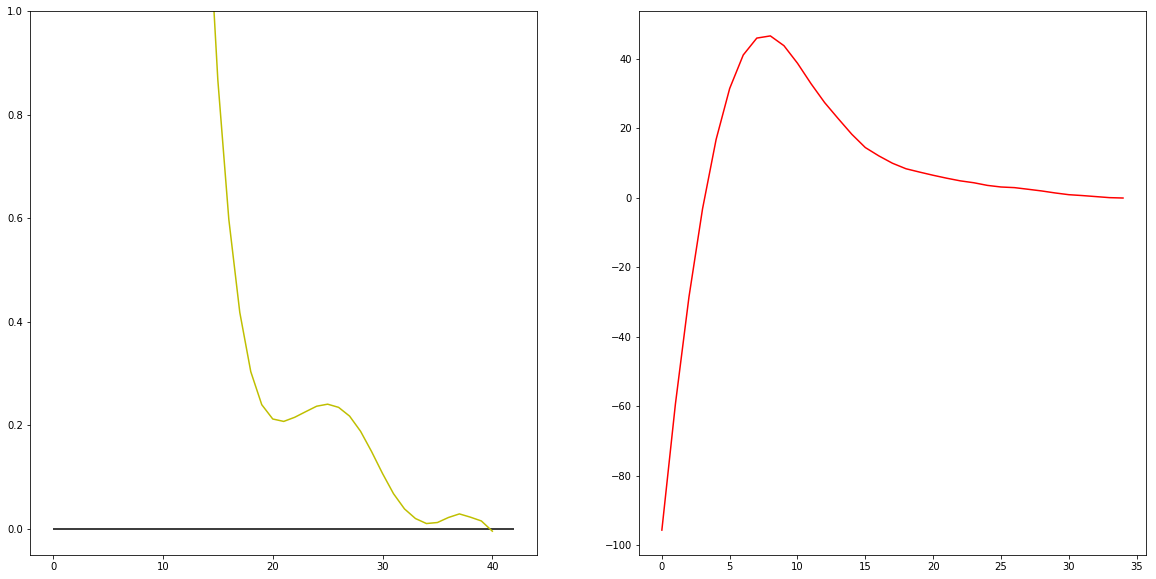

In [69]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,10))
axs[0].plot(np.array(b_all[1:1+len(pair_knots)])*(6*0.1**3) , 'y')
axs[0].set_ylim(-0.05,1.0)
axs[0].hlines(0.0, 0, 42)
axs[1].plot(np.array(b_all[1+len(pair_knots):])*(6*0.1**3) , 'r')

[-1139.216, 0.0, -1136.414, -1136.755, -1190.27, -1127.151]
[-1139.2, -0.0, -1136.401, -1136.751, -1190.261, -1127.175]


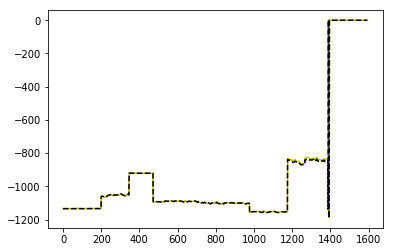

In [70]:
plt.plot(energy(b_all, X), 'y')
plt.plot(y, 'k--')
#plt.xlim(1448,)

print([round(z, 3) for z in energy(b_all, X)[bounds[-2]]])
print([round(z, 3) for z in y[bounds[-2]]])

In [71]:
stats_file = 'stats_bs_samples' # 'stats_samples'
with open(os.path.join(working, stats_file+'.pickle'), 'rb') as fi:
    stats_tpfx = pickle.load(fi, encoding='latin1')

stats_bsplinex = tpf_to_bsplines(stats_tpfx)

target_file = 'target_bs_samples'
with open(os.path.join(working, target_file+'.pickle'), 'rb') as fi:
    targetsx = pickle.load(fi, encoding='latin1')

len 50


In [72]:
stats_listx = [downselect(stats_bsplinex, pair_knots, edens_knots, bspline=True)]

for key in targets.keys():
    targetsx[key]['weight'] = 1.0
    
for i, stat in enumerate(stats_listx[-1:]):
    Xall, yall, weights, beta, bounds = make_input_matrices(targetsx, stat, keytrj=tkeys)

bounds [slice(0, 200, 1), slice(200, 346, 1), slice(346, 472, 1), slice(472, 708, 1), slice(708, 841, 1), slice(841, 977, 1), slice(977, 1176, 1), slice(1176, 1267, 1), slice(1267, 1389, 1), slice(1389, 1410, 1), slice(1410, 1418, 1), slice(1418, 1426, 1), slice(1426, 1436, 1), slice(1436, 1448, 1), slice(1448, 1454, 1)]
weights [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


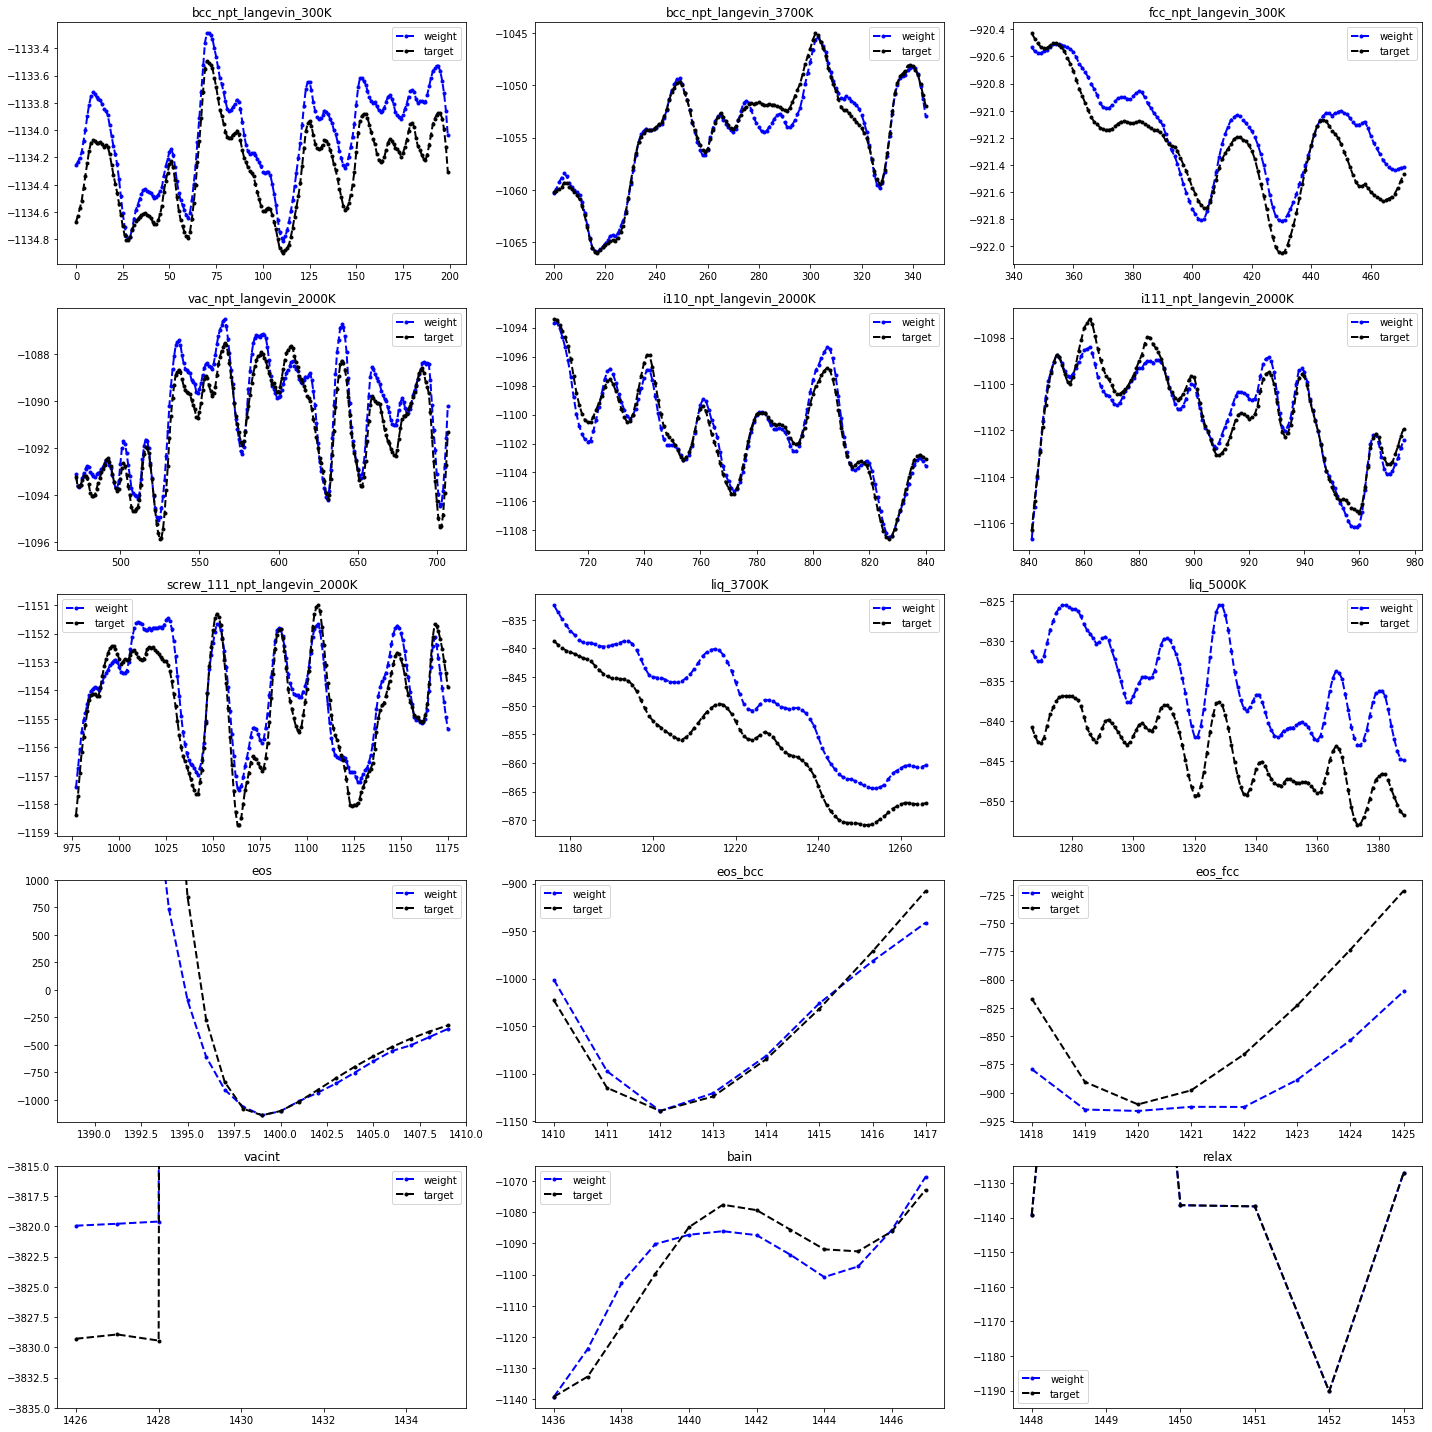

In [73]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(20,20))
    
for k, trj in enumerate(tkeys):
        
    i, j = divmod(k, 3)

    axes[i,j].set_title(trj)
        
    rr = list(range(len(Xall[0])))[bounds[k]][:]

    axes[i,j].plot(rr, energy(b_all, Xall)[bounds[k]][:], 'b.--', lw=2, label='weight')

    axes[i,j].plot(rr, yall[bounds[k]][:], 'k.--', lw=2, label='target')
    axes[i,j].legend()
    
    if trj == 'relax':
        axes[i,j].set_ylim(-1195, -1125)
        
    if trj == 'vacint':
        axes[i,j].set_ylim(-3835, -3815)
#        axes[i,j].set_xlim(1390,1392)
        
    if trj == 'eos':
        axes[i,j].set_ylim(-1200,1000)
        #axes[i,j].set_xlim(rr[0],1396)
        
    #axes[i,j].set_xlim(*bounds[k][0])
    #axes[i,j].set_ylim(*bounds[k][1])

plt.tight_layout()

In [74]:
p_knots = np.array(pair_knots)+0.4
print(p_knots)
e_knots = np.array(edens_knots)+0.4
print(e_knots)
n_edens = len(e_knots)

[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85 4.95 5.05 5.15 5.25 5.35 5.45]
[1.45 1.55 1.65 1.75 1.85 1.95 2.05 2.15 2.25 2.35 2.45 2.55 2.65 2.75
 2.85 2.95 3.05 3.15 3.25 3.35 3.45 3.55 3.65 3.75 3.85 3.95 4.05 4.15
 4.25 4.35 4.45 4.55 4.65 4.75 4.85]


In [75]:
def _bspline_coeffs_to_tpf(n_tot):
    """
    Finds b-spline coefficients reproducing a single cubic
    functin (rc-r)**3
    """

    penalty = [1.0, -4.0, 6.0, -4.0, 1.0]
    o = 4
    P = np.zeros((n_tot+4, n_tot), dtype=float)
    for i in range(n_tot+4):
        #ii = i - 4
        for j, p in enumerate(penalty):
            if i+j-o < 0 or i+j-o > n_tot-1:
                continue
            P[i, i+j-o] = p

    return P

In [76]:
M = _bspline_coeffs_to_tpf(41)

In [77]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
b11_ext = np.array(list(b_all[1:-n_edens]))#*(6*0.1**3)
print(b11_ext)
tpf_coeff = M.dot(b11_ext)
print(tpf_coeff)

[ 4.92289978e+03  4.28664798e+03  3.69999163e+03  3.16311467e+03
  2.67608939e+03  2.23839624e+03  1.84881977e+03  1.50589970e+03
  1.20778052e+03  9.52282853e+02  7.36530568e+02  5.57111521e+02
  4.10960084e+02  2.95508852e+02  2.08130623e+02  1.44541442e+02
  9.96768568e+01  6.96951354e+01  5.06228309e+01  3.99962745e+01
  3.53891378e+01  3.46071715e+01  3.59324447e+01  3.77369519e+01
  3.94987352e+01  4.01578637e+01  3.91318371e+01  3.63124833e+01
  3.14272545e+01  2.49184281e+01  1.78357608e+01  1.13388135e+01
  6.44203352e+00  3.33752646e+00  1.73021319e+00  2.06024594e+00
  3.67123592e+00  4.83362071e+00  3.78725430e+00  2.56284050e+00
 -7.24322230e-01]
[ 4.92289978e+03 -1.54049511e+04  1.60907984e+04 -5.60856309e+03
 -1.11639787e-01 -5.91871115e-01 -6.95861877e-01 -2.44846931e-01
 -3.95255159e-01 -3.23814594e-01 -6.96798605e-01 -5.35992726e-01
  3.46512223e-01  4.98221467e-01 -5.97953419e-02 -1.65675237e+00
 -7.80498977e-01  1.22272056e+00 -1.31714317e-01  1.50977796e+00
  3.734

In [78]:
Medens = _bspline_coeffs_to_tpf(35)

In [79]:
#b11_ext = np.array([4.2e3, 3.6e3, 3.10e3, 2.65e3] + list(b_weight11[2:]))*(6*0.1**3)
ed11_ext = np.array(list(b_all[-n_edens:]))#*(6*0.1**3)
print(ed11_ext)
edens_coeff = Medens.dot(ed11_ext)
print(edens_coeff)

[-1.59290128e+04 -9.88089691e+03 -4.74588467e+03 -5.25041507e+02
  2.79716306e+03  5.24204825e+03  6.84702625e+03  7.65728503e+03
  7.76189085e+03  7.29408376e+03  6.45203078e+03  5.46957529e+03
  4.56593549e+03  3.79746313e+03  3.04952817e+03  2.41000539e+03
  2.00897110e+03  1.65815401e+03  1.39308056e+03  1.23349356e+03
  1.08108126e+03  9.40528262e+02  8.13591973e+02  7.22463551e+02
  5.95888186e+02  5.18878817e+02  4.88408897e+02  4.10192363e+02
  3.29473407e+02  2.33075475e+02  1.50170292e+02  1.08071867e+02
  5.86321048e+01  8.47998479e+00 -9.59805992e+00]
[-1.59290128e+04  5.38351542e+04 -6.07963738e+04  2.28891669e+04
  1.65958911e+01  5.78875369e+00  1.60929531e+01  7.77581929e+00
  4.38782379e+01  4.41738316e+01  6.49269556e+01  3.56763601e+01
 -1.46251877e+01 -1.62866430e+02 -1.70981812e+02  2.02504824e+02
  4.22015424e+01 -3.18347595e+02  2.23797699e+02 -1.57836056e+01
 -1.18054567e+02  1.02996367e+02 -2.92722254e+00  2.04337691e+01
 -9.34459720e+01  1.56267748e+02 -8.8039

In [80]:
p_knot = [1.05, 1.15, 1.25, 1.35] + list(p_knots)
print(len(tpf_coeff), len(p_knot))
e_knot = [1.05, 1.15, 1.25, 1.35] + list(e_knots)
print(len(edens_coeff), len(e_knot))

45 45
39 39


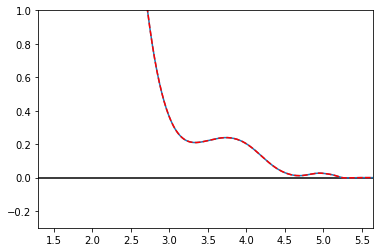

In [81]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[1:-n_edens], p_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, tpf_coeff, p_knot) for r in rr], 'r--')
plt.ylim(-0.3,1)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

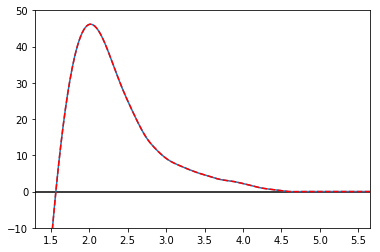

In [82]:
from statmechlib.forcefields import f_embed, f_dens, f_spline3

rr = np.linspace(1.3, 5.65, 436)

plt.plot(rr, [make_bspline(b_all[-n_edens:], p_knot, r) for r in rr])
plt.xlim(1.3,)

#print(rr)
bs_target = [make_bspline(b_all[-n_edens:], e_knot, r) for r in rr]
plt.plot(rr, [f_spline3(r, edens_coeff, e_knot) for r in rr], 'r--')
plt.ylim(-10,50)
plt.xlim(4,5)
plt.xlim(rr[0], rr[-1])
plt.hlines(0.0, rr[0], rr[-1])
plt.savefig('pair_potential')

In [1051]:
tpf_coeff

array([ 4.93218697e+03, -1.54368622e+04,  1.61274254e+04, -5.62274833e+03,
       -1.47906946e-01, -3.13620165e-01, -4.08286684e-01, -5.19216357e-01,
       -1.07142531e-01, -9.78111874e-01, -5.65040881e-01, -5.76428841e-01,
       -8.73166970e-02,  6.43932880e-01,  3.68489519e-01, -1.69483753e+00,
        2.80375065e-02,  7.46931302e-01, -3.85956855e-02,  7.21828595e-01,
        3.67567888e-01,  3.01756357e-01,  2.24032521e-01,  6.60075966e-01,
        7.91887470e-01, -7.41342637e-02,  5.82311980e-01,  1.33485657e-01,
       -2.78216008e-01,  4.67844416e-01,  4.71539397e-01, -3.10649519e-02,
        8.81061163e-02, -8.55529107e-01,  4.75554556e-01, -3.06920406e-01,
       -6.50017472e-01, -9.51269250e-01, -1.97333172e-01,  3.90442475e+00,
       -4.33438903e+00,  7.99138005e+00, -1.00539559e+01,  4.64897825e+00,
       -4.50700625e-01])

In [1052]:
edens_coeff

array([-1.63236674e+04,  5.52716069e+04, -6.25859363e+04,  2.36444082e+04,
        2.48841097e+01,  2.27463178e+01,  5.13777578e+00,  3.03826064e+01,
        1.20928483e+01,  4.00974110e+01,  3.76133057e+01,  4.46071681e+01,
       -1.70561970e+01, -1.62813120e+02, -1.86474253e+02,  2.69099401e+02,
       -3.93947988e+00, -3.00478168e+02,  2.24367638e+02, -6.11834429e+01,
       -6.03324114e+01,  6.38041398e+01,  3.30624420e+01, -9.47598615e+00,
       -9.15580302e+01,  1.69855123e+02, -8.26720584e+01, -1.06145284e+02,
        1.39248441e+02, -3.53257164e+01,  2.88901244e+00,  8.94012477e+00,
       -4.79738520e+01,  1.02747729e+01,  8.09051718e+01, -8.54107011e+01,
        1.61770241e+00,  2.83272850e+01, -5.52559051e+00])

In [1053]:
params = {
    'hyperparams':{'pair':[], 'edens':[]},
    'params':{'pair':[], 'edens':[]}}
params['hyperparams']['pair'] = p_knot
params['params']['pair'] = tpf_coeff
params['hyperparams']['edens'] = e_knot
params['params']['edens'] = edens_coeff
params['params']['embed'] = [-1.0, b_all[0]]

In [1054]:
param_list = [params]
param_list

[{'hyperparams': {'pair': [1.05,
    1.15,
    1.25,
    1.35,
    1.4500000000000002,
    1.5500000000000003,
    1.65,
    1.75,
    1.85,
    1.9500000000000002,
    2.0500000000000003,
    2.15,
    2.25,
    2.35,
    2.4499999999999997,
    2.5500000000000003,
    2.65,
    2.75,
    2.85,
    2.9499999999999997,
    3.0500000000000003,
    3.15,
    3.25,
    3.35,
    3.4499999999999997,
    3.5500000000000003,
    3.65,
    3.7500000000000004,
    3.85,
    3.9499999999999997,
    4.050000000000001,
    4.15,
    4.250000000000001,
    4.3500000000000005,
    4.45,
    4.550000000000001,
    4.65,
    4.750000000000001,
    4.8500000000000005,
    4.95,
    5.050000000000001,
    5.15,
    5.250000000000001,
    5.3500000000000005,
    5.45],
   'edens': [1.05,
    1.15,
    1.25,
    1.35,
    1.4500000000000002,
    1.5500000000000003,
    1.65,
    1.75,
    1.85,
    1.9500000000000002,
    2.0500000000000003,
    2.15,
    2.25,
    2.35,
    2.4499999999999997,
    2.550

In [1055]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

for params in param_list[-1:]:
    params_to_pickle(params, file_name)#, encoding='latin1', protocol=3)

No existing params file, creating a new one.


In [1056]:
file_name = os.path.join(working, "params_final_from_marica.pickle")

with open(file_name, 'rb') as fi:
    params_store = pickle.load(fi)
#params_store[-1]

In [1057]:
print('pair')

for c, k in zip(tpf_coeff, p_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))

print('edens') 
for c, k in zip(edens_coeff, e_knot):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, round(k, 2)))
        
print('embed')
print(-1.0, b_all[0])
#print(-4.42166597e-01,  1.12818607e-04)
#print(-4.49779872e-01,  1.09664665e-04)

pair
+4932.1869694107445d0*(1.05d0 - r)**3*H(1.05d0 - r)
-15436.862211702473d0*(1.15d0 - r)**3*H(1.15d0 - r)
+16127.425437218692d0*(1.25d0 - r)**3*H(1.25d0 - r)
-5622.748325763732d0*(1.35d0 - r)**3*H(1.35d0 - r)
-0.14790694554176298d0*(1.45d0 - r)**3*H(1.45d0 - r)
-0.31362016483035404d0*(1.55d0 - r)**3*H(1.55d0 - r)
-0.4082866838243717d0*(1.65d0 - r)**3*H(1.65d0 - r)
-0.5192163570127377d0*(1.75d0 - r)**3*H(1.75d0 - r)
-0.10714253090918646d0*(1.85d0 - r)**3*H(1.85d0 - r)
-0.9781118739119847d0*(1.95d0 - r)**3*H(1.95d0 - r)
-0.5650408805331608d0*(2.05d0 - r)**3*H(2.05d0 - r)
-0.5764288405721345d0*(2.15d0 - r)**3*H(2.15d0 - r)
-0.08731669696499011d0*(2.25d0 - r)**3*H(2.25d0 - r)
+0.6439328795590882d0*(2.35d0 - r)**3*H(2.35d0 - r)
+0.3684895193171087d0*(2.45d0 - r)**3*H(2.45d0 - r)
-1.6948375332796104d0*(2.55d0 - r)**3*H(2.55d0 - r)
+0.028037506535497414d0*(2.65d0 - r)**3*H(2.65d0 - r)
+0.7469313024511166d0*(2.75d0 - r)**3*H(2.75d0 - r)
-0.03859568546306491d0*(2.85d0 - r)**3*H(2.85d0 - r)
+

In [ ]:
par = param_list[2]
print('pair')
for c, k in zip(par['params']['pair'], par['hyperparams']['pair']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('edens')   
for c, k in zip(par['params']['edens'], par['hyperparams']['edens']):
    if c > 0.0:
        print('+{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
    else:
        print('{0}d0*({1}d0 - r)**3*H({1}d0 - r)'.format(c, k))
print('embed')    
par['params']['embed']